# 종합 통계 실습

## 비즈니스 시나리오

> 여러분은 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴입니다. \
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다. \
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립해 주세요.

---

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득 고객과 저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육, 결혼, 캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가? |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

### 데이터 셋 개요

| 항목 | 내용 |
|------|------|
| **출처** | Kaggle |
| **URL** | https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis |
| **크기** | 약 2,240행 × 29열 |
| **파일명** | `marketing_campaign.csv` |
| **도메인** | 식품·와인 유통 기업 |

**설명:** 고객 성격 분석은 기업의 이상적인 고객을 심층 분석하는 방법론이다. 고객 세그먼트별 니즈·행동·관심사를 파악해 제품 및 마케팅을 최적화하는 데 활용한다.

---

### 변수 목록

#### 고객 정보

| # | 변수명 | 설명 |
|---|--------|------|
| 1 | `ID` | 고객 고유 식별자 |
| 2 | `Year_Birth` | 고객 출생연도 |
| 3 | `Education` | 최종 학력 |
| 4 | `Marital_Status` | 결혼 상태 |
| 5 | `Income` | 연간 가구 소득 |
| 6 | `Kidhome` | 가구 내 어린 자녀 수 |
| 7 | `Teenhome` | 가구 내 십대 자녀 수 |
| 8 | `Dt_Customer` | 고객 등록일 |
| 9 | `Recency` | 마지막 구매 이후 경과 일수 |

---

#### 소비 패턴 — 최근 2년간 지출 금액

| # | 변수명 | 설명 |
|---|--------|------|
| 10 | `MntWines` | 와인 지출 금액 |
| 11 | `MntFruits` | 과일 지출 금액 |
| 12 | `MntMeatProducts` | 육류 지출 금액 |
| 13 | `MntFishProducts` | 생선 지출 금액 |
| 14 | `MntSweetProducts` | 과자·디저트 지출 금액 |
| 15 | `MntGoldProds` | 골드 지출 금액 |

---

#### 캠페인 반응

| # | 변수명 | 설명 |
|---|--------|------|
| 16 | `NumDealsPurchases` | 할인 적용 구매 횟수 |
| 17 | `NumWebPurchases` | 웹사이트를 통한 구매 횟수 |
| 18 | `NumCatalogPurchases` | 카탈로그를 통한 구매 횟수 |
| 19 | `NumStorePurchases` | 오프라인 매장 구매 횟수 |
| 20 | `NumWebVisitsMonth` | 최근 한 달간 웹사이트 방문 횟수 |
| 21 | `AcceptedCmp3` | 3차 캠페인 제안 수락 여부 (1=수락, 0=거절) |
| 22 | `AcceptedCmp4` | 4차 캠페인 제안 수락 여부 |
| 23 | `AcceptedCmp5` | 5차 캠페인 제안 수락 여부 |
| 24 | `AcceptedCmp1` | 1차 캠페인 제안 수락 여부 |
| 25 | `AcceptedCmp2` | 2차 캠페인 제안 수락 여부 |
| 26 | `Complain` | 최근 2년 내 불만 제기 여부 (1=있음, 0=없음) |
| 27 | `Z_CostContact` | 상수값 3 — 캠페인 1회당 연락 비용 |
| 28 | `Z_Revenue` | 상수값 11 — 캠페인 성공 시 수익 |
| 29 | `Response` | 최종 캠페인 제안 수락 여부 **(타깃 변수)** |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import (
    proportions_ztest, proportion_confint, proportion_effectsize
)
from statsmodels.stats.power import NormalIndPower, TTestIndPower
import pingouin as pg
import warnings
import platform

warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

---
## Part 0: 데이터 전처리 (코드 제공)

아래 코드를 실행하여 분석에 사용할 데이터프레임 `df`를 준비합니다.
모든 파생변수가 생성되고 이상치가 제거된 상태에서 Part 1부터 분석을 시작합니다.

### 0-1. 데이터 로드 및 결측치 처리

In [2]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(f"원본 데이터: {df.shape[0]}행 × {df.shape[1]}열")
print(f"Income 결측치: {df['Income'].isnull().sum()}개")

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f"→ Income 중앙값({df['Income'].median():,.0f})으로 대치 완료")

원본 데이터: 2240행 × 29열
Income 결측치: 24개
→ Income 중앙값(51,382)으로 대치 완료


### 0-2. 파생변수 생성

In [3]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df['Age'] = 2024 - df['Year_Birth']
df['Total_Spending'] = df[spending_cols].sum(axis=1)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
df['Total_Accepted'] = df[campaign_cols].sum(axis=1)
df['Has_Children'] = (df['Kidhome'] + df['Teenhome']) > 0
df['Income_Group'] = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High'])

bins = [0, 39, 49, 59, 200]
labels_age = ['30대 이하', '40대', '50대', '60대 이상']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels_age)

edu_map = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate',
           'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map)

marital_map = {'Married': 'Together', 'Together': 'Together',
               'Single': 'Single', 'Divorced': 'Single', 'Widow': 'Single',
               'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'}
df['Marital_Group'] = df['Marital_Status'].map(marital_map)

df['Campaign_Response'] = df['Total_Accepted'] > 0

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days

print("파생변수 생성 완료:")
for col in ['Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
            'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
            'Marital_Group', 'Campaign_Response', 'Customer_Days']:
    print(f"  - {col}: {df[col].dtype}")

파생변수 생성 완료:
  - Age: int64
  - Total_Spending: int64
  - Total_Purchases: int64
  - Total_Accepted: int64
  - Has_Children: bool
  - Income_Group: category
  - Age_Group: category
  - Education_Group: object
  - Marital_Group: object
  - Campaign_Response: bool
  - Customer_Days: int64


### 0-3. 이상치 제거

In [4]:
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after = len(df)
print(f"이상치 제거: {n_before}행 → {n_after}행 ({n_before - n_after}행 제거)")
print(f"\n최종 데이터 요약:")
print(f"  Age 범위: {df['Age'].min()} ~ {df['Age'].max()}")
print(f"  Income 범위: {df['Income'].min():,.0f} ~ {df['Income'].max():,.0f}")
print(f"\n데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!")

이상치 제거: 2240행 → 2236행 (4행 제거)

최종 데이터 요약:
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!


---
## Part 1: 탐색적 데이터 분석 — "고객은 누구인가?"

기술통계량과 시각화를 통해 FreshCart 고객의 특성을 파악합니다.

### 문제 1-1. 중심경향과 산포도

`Income`, `Total_Spending`, `Age` 세 변수에 대해 다음을 계산하세요.

| 중심경향 | 산포도 |
|----------|--------|
| 평균(mean) | 분산(variance) |
| 중앙값(median) | 표준편차(std) |
| 최빈값(mode) | 사분위범위(IQR) |
| 5% 절사평균(trimmed mean) | 변동계수(CV) |

In [5]:
# TODO 1-1(a): Income, Total_Spending, Age의 중심경향 — 평균, 중앙값, 최빈값, 5% 절사평균

target_cols = ['Income', 'Total_Spending', 'Age']

answer_1_1 = {} #각 컬럼의 중심경향값을 저장할 딕셔너리, {컬럼: {각각의 중심경향값}}

for col in target_cols:
    mean_1 = df[col].mean()
    median_1 = df[col].median()
    mode_1 = df[col].mode()[0]
    trimed_mean_1 = stats.trim_mean(df[col], 0.05)
    
    answer_1_1[col]={
        '평균': round(mean_1, 2),
        '중앙값': round(median_1, 2),
        '최빈값': round(mode_1, 2),
        '5% 절사평균': round(trimed_mean_1, 2)
    }
    
df_answer_1_1 = pd.DataFrame(answer_1_1).T # .T를 하지 않으면 키가 열이 되고, 값이 행이 되기 때문에 뒤바꾼 것이다.
display(df_answer_1_1)   

,평균,중앙값,최빈값,5% 절사평균
Income,51952.61,51381.5,51381.5,51740.15
Total_Spending,605.99,396.5,46.0,561.12
Age,55.10,54.0,48.0,55.07


In [6]:
# TODO 1-1(b): Income, Total_Spending, Age의 산포도 — 분산(ddof=1), 표준편차, IQR, CV(%)

answer_1_2 = {}

for col in target_cols:
    val_1 = df[col].var(ddof=1)
    std_1 = df[col].std(ddof=1) 
    iqr_1 = df[col].quantile(0.75) - df[col].quantile(0.25)
    cv_pct_1 = (std_1 / df[col].mean())*100
    
    answer_1_2[col]={
        '분산': round(val_1, 2),
        '표준편차': round(std_1, 2),
        'IQR': round(iqr_1, 2),
        'CV(%)': round(cv_pct_1, 2)
    }
    
df_answer_1_2 = pd.DataFrame(answer_1_2).T
display(df_answer_1_2) 

,분산,표준편차,IQR,CV(%)
Income,4.584509e+08,21411.47,32773.25,41.21
Total_Spending,3.622417e+05,601.87,976.50,99.32
Age,1.369700e+02,11.70,18.00,21.24


### 문제 1-2. 분포 시각화

- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선
- **(b)** Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수 출력
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

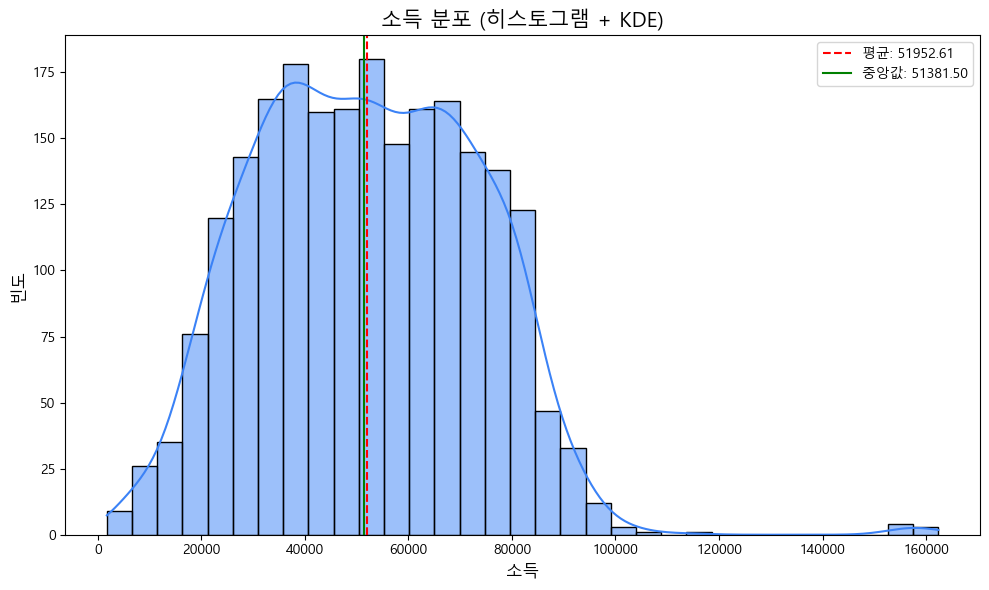

In [14]:
# TODO 1-2(a): Income 히스토그램 + KDE
plt.figure(figsize=(10, 6))

income_mean = df['Income'].mean()
income_median = df['Income'].median()

sns.histplot(data=df, x='Income', kde=True, color=COLORS['blue'], edgecolor='black')

plt.axvline(income_mean, color='red', linestyle='--', label=f'평균: {income_mean:.2f}')
plt.axvline(income_median, color='green', linestyle='-', label=f'중앙값: {income_median:.2f}')

plt.title("소득 분포 (히스토그램 + KDE)", fontsize=15)
plt.xlabel("소득", fontsize=12)
plt.ylabel("빈도", fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

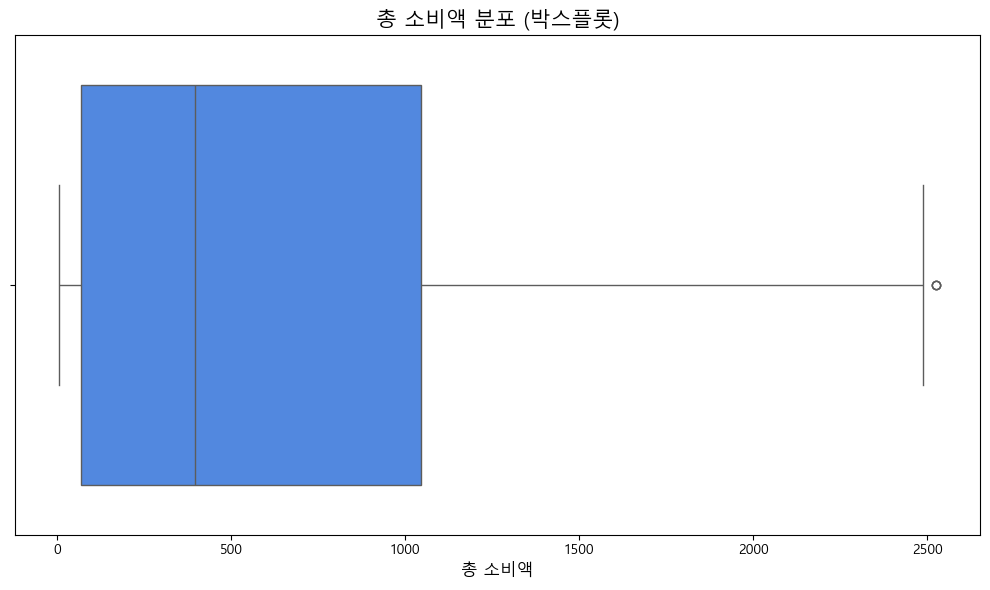

IQR 기준 Total_Spending의 이상치 개수: 3개


In [15]:
# TODO 1-2(b): Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수

q1 = df['Total_Spending'].quantile(0.25)
q3 = df['Total_Spending'].quantile(0.75)
iqr = q3 - q1

# 상한치/하한치 설정
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# 이상치가 담긴 데이터프레임 생성
outliers_df = df[(df['Total_Spending'] > upper_bound)|(df['Total_Spending'] < lower_bound)]

# 시각화
plt.figure(figsize=(10, 6))

sns.boxplot(data=df, x='Total_Spending', color=COLORS['blue'])

plt.title("총 소비액 분포 (박스플롯)", fontsize=15)
plt.xlabel("총 소비액", fontsize=12)

plt.tight_layout()
plt.show()

# 이상치 개수
print(f'IQR 기준 Total_Spending의 이상치 개수: {len(outliers_df)}개')

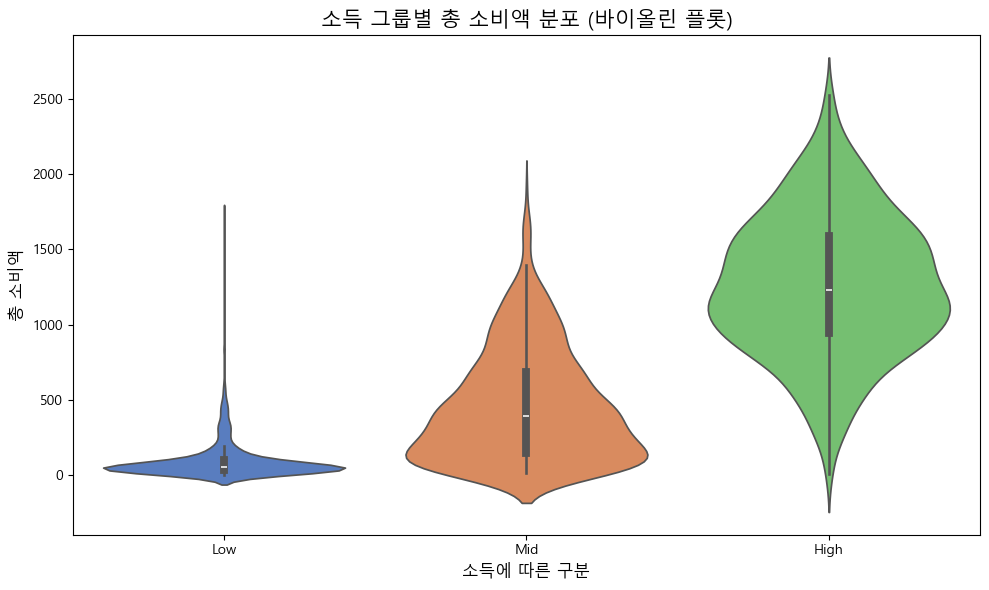

In [16]:
# TODO 1-2(c): Income_Group별 Total_Spending 바이올린 플롯

plt.figure(figsize=(10, 6))

sns.violinplot(data=df, x='Income_Group', y='Total_Spending', palette='muted')

plt.title("소득 그룹별 총 소비액 분포 (바이올린 플롯)", fontsize=15)
plt.xlabel("소득에 따른 구분", fontsize=12)
plt.ylabel("총 소비액", fontsize=12)

plt.tight_layout()
plt.show()

### 문제 1-3. 왜도와 첨도

6개 소비 카테고리(MntWines ~ MntGoldProds)의 왜도(Skewness)와 첨도(Kurtosis)를 계산하고,
2×3 히스토그램 그리드를 그려 분포 형태를 비교하세요.

**왜도 해석**
- 왜도 > 0: 오른쪽 꼬리가 긴 분포 
- 왜도 < 0: 왼쪽 꼬리가 긴 분포 
- 왜도 ≈ 0: 좌우 대칭에 가까운 분포

**첨도 해석** 
- 초과 첨도 > 0: 정규분포보다 중앙이 뾰족하고 꼬리가 두꺼운 분포 
- 초과 첨도 < 0: 정규분포보다 중앙이 평평하고 꼬리가 얇은 분포
- 초과 첨도 ≈ 0: 정규분포와 유사한 형태

In [17]:
spending_names = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'],
              COLORS['emerald'], COLORS['amber'], COLORS['rose']]

# TODO 1-3(a): 6개 카테고리의 왜도/첨도 계산 및 출력
# spending_cols: 소비와 관련된 컬럼 모음

skew_values = df[spending_cols].skew() # 왜도
kurt_values = df[spending_cols].kurt() # 첨도

spending_df = pd.DataFrame({
    '왜도' : skew_values.round(2),
    '첨도' : kurt_values.round(2)
})

# 행 이름을 spending_names로 변경하기
name_map = dict(zip(spending_cols, spending_names)) # Key와 Value를 1:1 매핑하여 딕셔너리 생성

spending_df = spending_df.rename(index=name_map)

display(spending_df)

,왜도,첨도
Wines,1.18,0.60
Fruits,2.10,4.07
Meat,2.09,5.53
Fish,1.92,3.10
Sweets,2.14,4.37
Gold,1.89,3.56


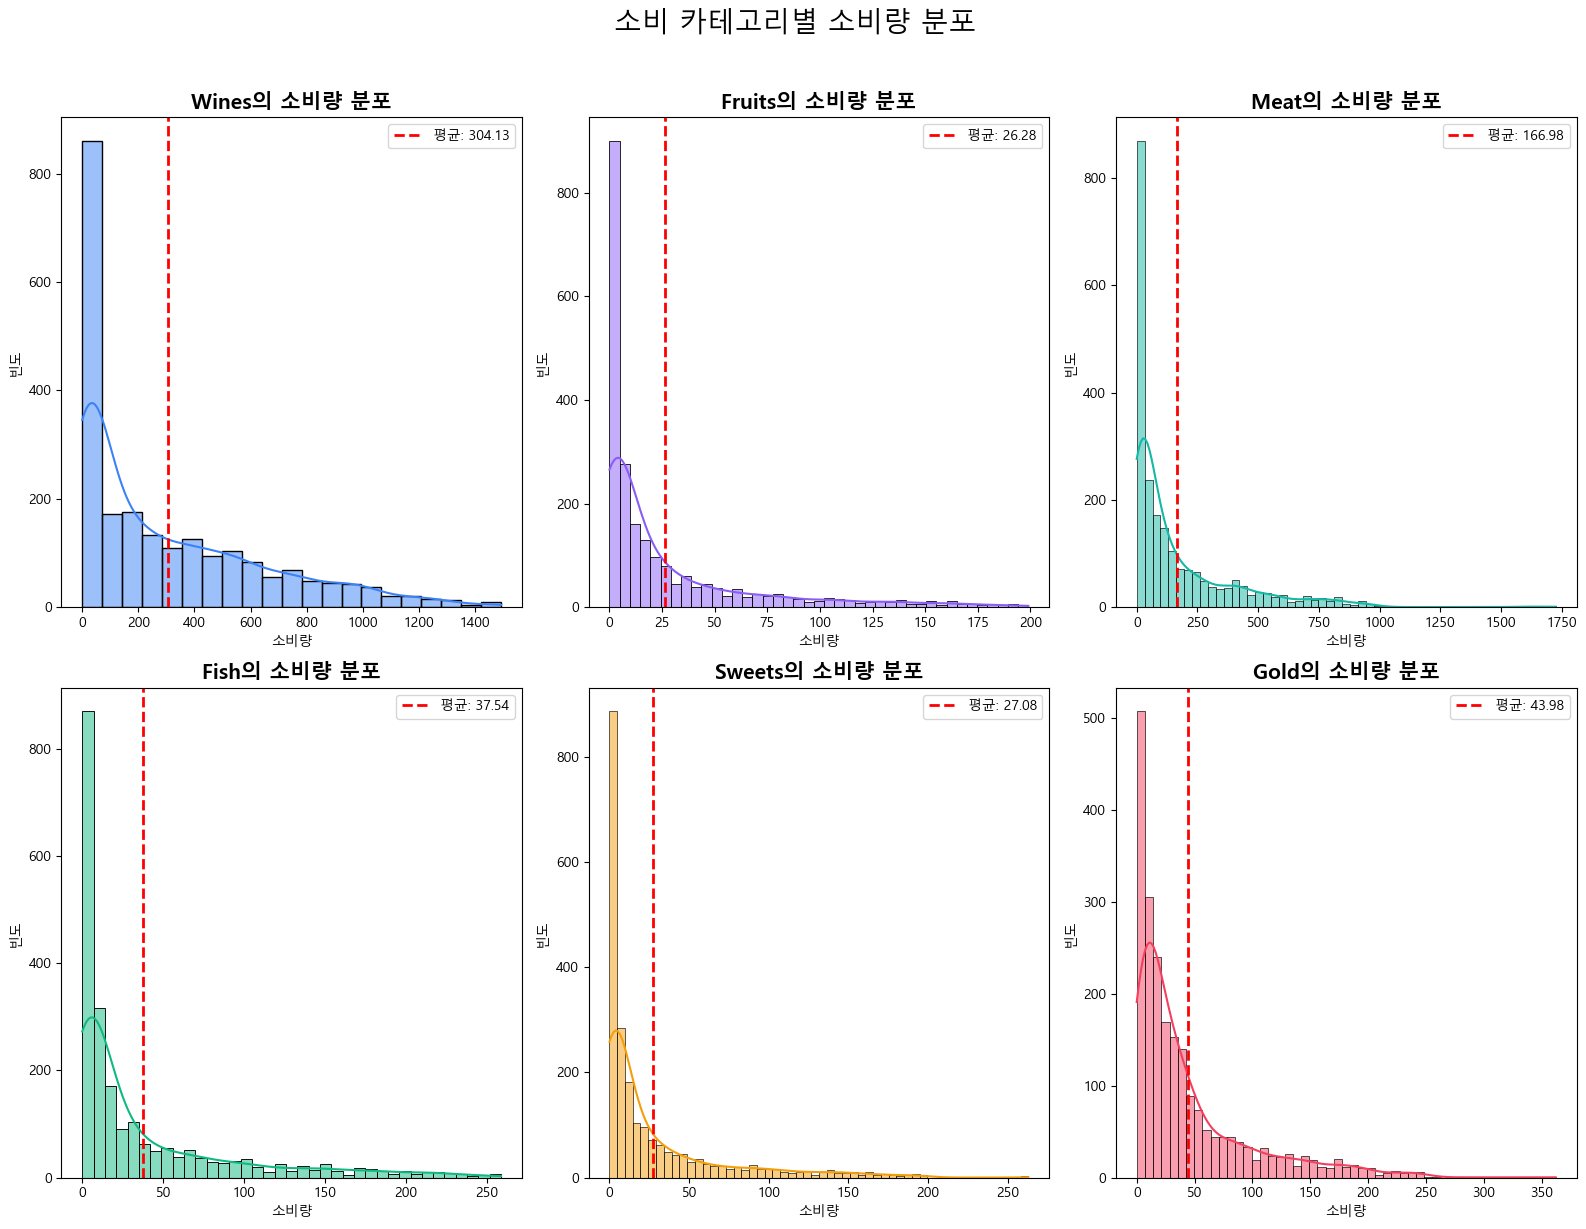

In [18]:
# TODO 1-3(b): 2×3 히스토그램 그리드 (각 카테고리 분포 + 평균선)
fig, axes = plt.subplots(2, 3, figsize=(16, 12))

# 반복문을 사용해 6개의 히스토그램 표현
# 인덱스 계산방법: i(행의 순서) * (전체 열의 개수=3) + j(열의 순서)
for i in range(2):
    for j in range(3):
        index = i * 3 + j
        col = spending_cols[index]
        name = spending_names[index]
        color = hist_colors[index]
        
        # 히스토그램
        sns.histplot(data=df, x=col, kde=True, color=color, edgecolor='black', ax=axes[i,j])
        
        # 각 컬럼별 평균선
        mean_value = df[col].mean()
        axes[i,j].axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'평균: {mean_value:.2f}')
        
        # 제목, 축 제목, 범례
        axes[i, j].set_title(f"{name}의 소비량 분포", fontsize=15, fontweight='bold')
        axes[i, j].set_xlabel("소비량")
        axes[i, j].set_ylabel("빈도")
        axes[i, j].legend()
        
plt.suptitle("소비 카테고리별 소비량 분포", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()

### 문제 1-4. 비즈니스 인사이트 정리

Part 1의 분석 결과를 바탕으로 다음을 정리하세요.

1. 고객 특성 요약 (연령, 소득, 소비 특성)
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
3. 후속 분석에서 검증할 가설 (최소 3개)

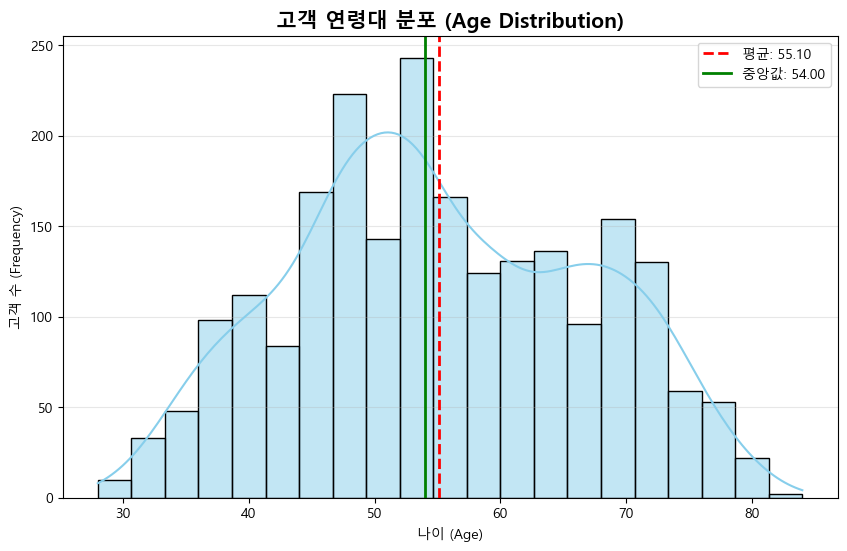

In [26]:
## 고객특성(연령) 분석을 위한 보조 자료
# 고객 나이(Age) 분포 시각화
plt.figure(figsize=(10, 6))

# 히스토그램과 KDE 곡선
sns.histplot(df['Age'], kde=True, color='skyblue', edgecolor='black')

# 평균선(빨간색)과 중앙값선(초록색) 추가
plt.axvline(df['Age'].mean(), color='red', linestyle='--', linewidth=2, label=f"평균: {df['Age'].mean():.2f}")
plt.axvline(df['Age'].median(), color='green', linestyle='-', linewidth=2, label=f"중앙값: {df['Age'].median():.2f}")

plt.title('고객 연령대 분포 (Age Distribution)', fontsize=15, fontweight='bold')
plt.xlabel('나이 (Age)')
plt.ylabel('고객 수 (Frequency)')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
# TODO 1-4: 비즈니스 인사이트 정리
print(f"\n 1. 고객 특성 요약(연령, 소득, 소비 특성)")
print(f"    연령: 평균 연령은 55.1세이고, 중앙값은 54세이며, 변동계수는 21.24%로 낮은 편이다.")
print(f"         대부분의 고객이 40대에서 60대 초반으로 중장년층 고객의 비율이 높다.")
print(f"    소득: 소득의 평균, 중앙값, 5% 절사평균이 모두 비슷한 값을 갖고 있다.")
print(f"         고객층의 소득 분포는 안정적인 편이다.")
print(f"    소비 특성: 변동계수가 99.32%로, 고객 간 지출 격차가 매우 크다.")
print(f"             와인과 육류 소비가 가장 많은 것을 통해 와인과 육류가 매출의 핵심 동력임을 알 수 있다.")

print(f"\n 2. 핵심 발견 사항(분포 특성, 그룹 간 차이)")
print(f"    분포 특성: 소비량의 분포를 확인한 6개의 카테고리가 모두 소수의 대량 구매 고객과 다수의 소량 구매 고객으로 명확히 구분된다는 것을 알 수 있다.")
print(f"    그룹 간 차이: 소득이 높은 high 그룹은 다른 그룹보다 소비가 많을 뿐만 아니라, 자신의 취향에 따라 지출규모의 변동성이 매우 크다.")
print(f"                소득이 비교적 낮은 low 그룹은 대부분의 소비액이 0 근처에 조밀하게 분포되어 있지만, 소득이 높아질수록 고객들의 소비 분포는 다양해진다.")

print(f"\n 3. 후속 분속에서 검증할 가설 3개")
print(f"    - 1번 가설: 소득 수준에 따라 선호하는 구매 방법(매장, 온라인, 카탈로그)에 통계적으로 유의미한 차이가 있을 것이다.")
print(f"    - 2번 가설: 자녀 유무에 따라 와인과 육류 소비량에 통계적으로 유의미한 차이가 있을 것이다.")
print(f"    - 3번 가설: 대량 구매를 하는 일부 고객이 전체 매출의 60% 이상에 기여하고 있을 것이다.")


 1. 고객 특성 요약(연령, 소득, 소비 특성)
    연령: 평균 연령은 55.1세이고, 중앙값은 54세이며, 변동계수는 21.24%로 낮은 편이다.
         대부분의 고객이 40대에서 60대 초반으로 중장년층 고객의 비율이 높다.
    소득: 소득의 평균, 중앙값, 5% 절사평균이 모두 비슷한 값을 갖고 있다.
         고객층의 소득 분포는 안정적인 편이다.
    소비 특성: 변동계수가 99.32%로, 고객 간 지출 격차가 매우 크다.
             와인과 육류 소비가 가장 많은 것을 통해 와인과 육류가 매출의 핵심 동력임을 알 수 있다.

 2. 핵심 발견 사항(분포 특성, 그룹 간 차이)
    분포 특성: 소비량의 분포를 확인한 6개의 카테고리가 모두 소수의 대량 구매 고객과 다수의 소량 구매 고객으로 명확히 구분된다는 것을 알 수 있다.
    그룹 간 차이: 소득이 높은 high 그룹은 다른 그룹보다 소비가 많을 뿐만 아니라, 자신의 취향에 따라 지출규모의 변동성이 매우 크다.
                소득이 비교적 낮은 low 그룹은 대부분의 소비액이 0 근처에 조밀하게 분포되어 있지만, 소득이 높아질수록 고객들의 소비 분포는 다양해진다.

 3. 후속 분속에서 검증할 가설 3개
    - 1번 가설: 소득 수준에 따라 선호하는 구매 방법(매장, 온라인, 카탈로그)에 통계적으로 유의미한 차이가 있을 것이다.
    - 2번 가설: 자녀 유무에 따라 와인과 육류 소비량에 통계적으로 유의미한 차이가 있을 것이다.
    - 3번 가설: 대량 구매를 하는 일부 고객이 전체 매출의 60% 이상에 기여하고 있을 것이다.


---
## Part 2: 확률분포 모델링 — "고객 행동은 어떤 패턴을 따르는가?"

실제 고객 데이터에 이론적 확률분포를 적합하여 고객 행동을 모델링합니다.

### 문제 2-1. 이항분포 — 캠페인 수락 모델링

`Response` 열에서 수락률 p를 계산하고, 이를 이항분포 B(n, p)에 적용합니다.

- **(a)** 10명 중 정확히 2명이 수락할 확률
  - B(n=10, p) 에서 P(X = 2) 계산

- **(b)** 10명 중 3명 이상이 수락할 확률
  - B(n=10, p) 에서 P(X ≥ 3) 계산

- **(c)** 이항분포 PMF 시각화
  - B(n=10, p) 의 모든 경우(X = 0, 1, ..., 10)에 대한
    이론 확률을 막대그래프로 그립니다.

- **(d)** n=100 으로 확장 — 세 가지 질문
  - **기대 수락자 수**: E(X) 계산
  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색

In [35]:
# TODO 2-1(a),(b): 수락률(p) 계산 + P(X=2), P(X≥3) 계산 및 출력
n_trial = 10

# 수락율(p): 최종 캠페인 제안을 수락한 고객의 비율로 계산(제안을 수락하면 1, 거절하면 0)
p = df['Response'].mean() # 0.14937388193202147

# P(X=2)
prob_a = stats.binom.pmf(2, n_trial, p)

# P(X≥3)
prob_b = stats.binom.sf(2, n_trial, p)

print(f"전체 수락률 (p): {p:.4f}")
print(f"(a) 10명 중 정확히 2명이 수락할 확률: {prob_a:.4f}")
print(f"(b) 10명 중 3명 이상이 수락할 확률: {prob_b:.4f}")

전체 수락률 (p): 0.1494
(a) 10명 중 정확히 2명이 수락할 확률: 0.2752
(b) 10명 중 3명 이상이 수락할 확률: 0.1782


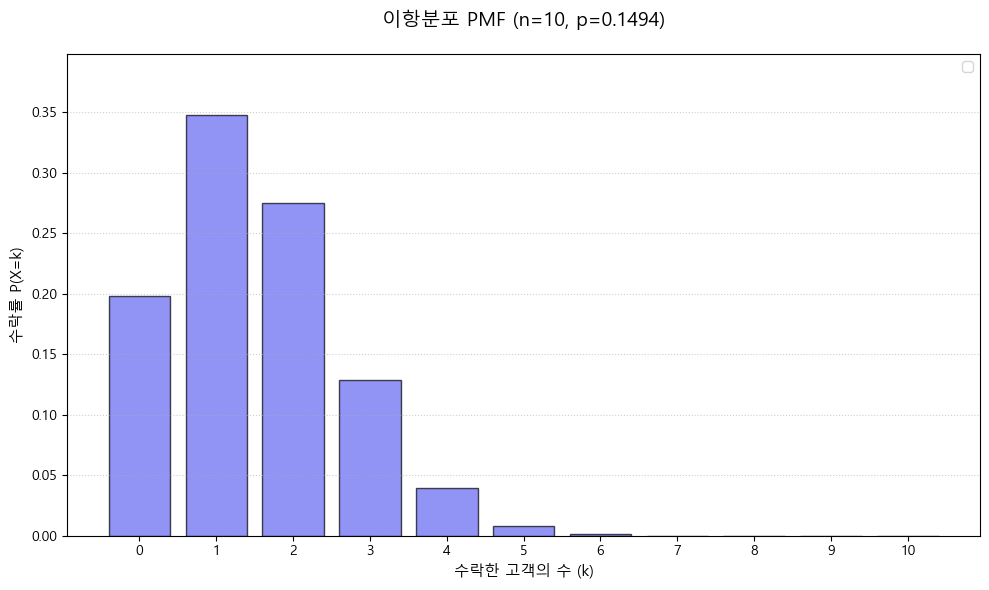

In [38]:
# TODO 2-1(c): 이항분포 PMF 시각화

# x축
x = np.arange(0,n_trial+1)

# pmf
pmf_value = stats.binom.pmf(x, n_trial, p)

# 시각화
plt.figure(figsize=(10,6))
plt.bar(x, pmf_value, color=COLORS['indigo'], alpha=0.7, edgecolor='black')

plt.title(f'이항분포 PMF (n=10, p={p:.4f})', fontsize=14, pad=20)
plt.xlabel('수락한 고객의 수 (k)', fontsize=11)
plt.ylabel('수락률 P(X=k)', fontsize=11)
plt.xticks(x)
plt.ylim(0, max(pmf_value) + 0.05)
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
# TODO 2-1(d): 100명 발송 시 기대 수락자, P(X≥15), 90% 보장 최소 수락 수
n_campaign = 100

# 기대값
expected_value = n_campaign * p

# P(X≥15)
prob_upper_15 = stats.binom.sf(14, n_campaign, p)

# 90% 보장 최소 수락 수
min_90_k = stats.binom.ppf(0.9, n_campaign, p)

print(f"--- n=100 확장 시뮬레이션 결과 ---")
print(f"1. 기대 수락자 수: {expected_value:.2f}명")
print(f"2. 15명 이상 수락할 확률: {prob_upper_15:.4f}")
print(f"3. 90% 확률로 최대 {min_90_k:.0f}명까지 발생 (보수적 상한선 가이드)")

--- n=100 확장 시뮬레이션 결과 ---
1. 기대 수락자 수: 14.94명
2. 15명 이상 수락할 확률: 0.5358
3. 90% 확률로 최대 20명까지 발생 (보수적 상한선 가이드)


### 문제 2-2. 포아송 분포 — 웹사이트 방문 모델링

`NumWebVisitsMonth`(월간 웹 방문 수)에 포아송 분포를 적합합니다.

- **(a)** λ 추정 및 적합 평가
  - 표본 평균으로 λ를 추정하고,
    표본 평균 ≈ 표본 분산인지 확인하여 포아송 분포 적합 여부를 평가합니다.

- **(b)** 실측 vs 이론 PMF 시각화
  - 각 방문 횟수(0회, 1회, 2회, ...)별 실제 비율(실측 PMF)과
    포아송 분포의 이론 확률(이론 PMF)을 막대그래프로 겹쳐 그려 비교합니다.

- **(c)** 포아송 분포 활용 — 두 가지 실무 시나리오
  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
       이를 서버가 처리해야 할 기준 용량으로 활용합니다.

In [46]:
web_visits = df['NumWebVisitsMonth']

# TODO 2-2(a): 람다 추정 및 포아송 적합 평가 (월간 웹 방문수 평균≈분산 값이 비슷한지 확인)
# 한달 간 웹사이트 방문자 수
Num_of_visitors = df['NumWebVisitsMonth']

lamda = Num_of_visitors.mean()
var_visitors = Num_of_visitors.var(ddof=1)

print(f"추정된 λ (평균): {lamda:.4f}") # 5.3189
print(f"표본 분산 (ddof=1): {var_visitors:.4f}") # 5.8898
print(f"분산/평균 비율: {var_visitors/lamda:.4f}") # 1.1073
print(f" \n 분산과 평균의 비율이 {var_visitors/lamda:.4f}을 보니 제작한 포아송 분포가 실제 데이터와 유사하다는 것을 알 수 있다.")
print(f"따라서 제작한 포아송 분포를 활용한 예측은 실제 데이터를 모두 분석한 결과와 유사할 것으로 사료된다.")

추정된 λ (평균): 5.3189
표본 분산 (ddof=1): 5.8898
분산/평균 비율: 1.1073
 
 분산과 평균의 비율이 1.1073을 보니 제작한 포아송 분포가 실제 데이터와 유사하다는 것을 알 수 있다.
따라서 제작한 포아송 분포를 활용한 예측은 실제 데이터를 모두 분석한 결과와 유사할 것으로 사료된다.


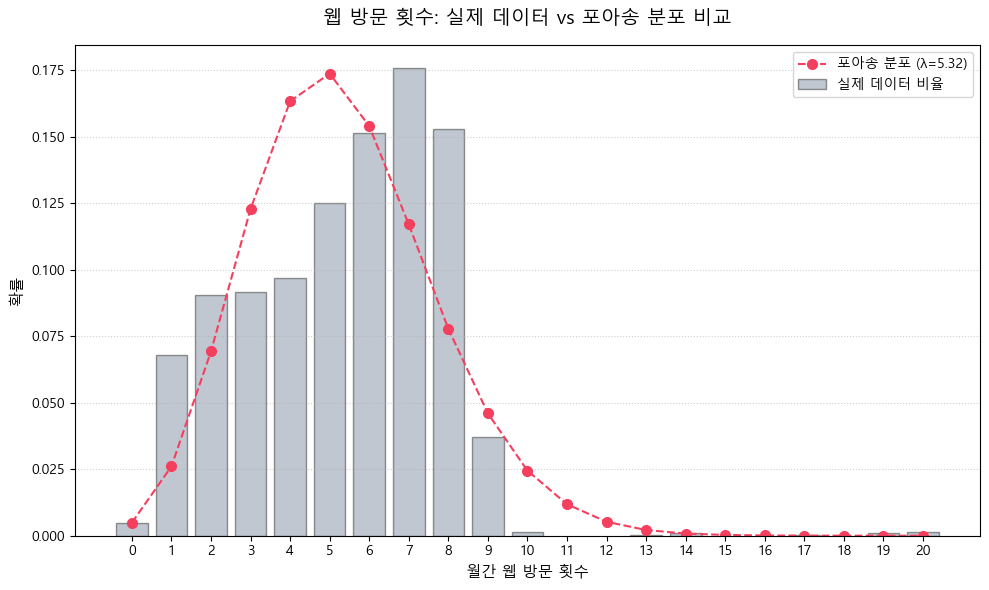

In [47]:
# TODO 2-2(b): 월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화 (두 그래프를 겹쳐서 그리기)
# 1. 데이터 준비
# 방문 횟수 범위 (0회부터 최대 방문 횟수까지)
max_visits = web_visits.max()
x = np.arange(0, max_visits + 1)

# 실제 데이터의 확률 분포 (Normalize=True로 비율 계산)
actual_prob = web_visits.value_counts(normalize=True).sort_index()

# 이론적 포아송 분포 확률 계산
theoretical_pmf = stats.poisson.pmf(x, lamda)

# 2. 시각화
plt.figure(figsize=(10, 6))

# 실측 데이터: 막대 그래프 (COLORS['slate'] 사용)
plt.bar(actual_prob.index, actual_prob.values, alpha=0.4, 
        label='실제 데이터 비율', color=COLORS['slate'], edgecolor='black')

# 이론 데이터: 꺾은선 그래프 (COLORS['rose'] 사용)
plt.plot(x, theoretical_pmf, marker='o', linestyle='--', 
         color=COLORS['rose'], label=f'포아송 분포 (λ={lamda:.2f})', markersize=7)

# 3. 그래프 스타일링 (한글 제목 및 축 제목 반영)
plt.title('웹 방문 횟수: 실제 데이터 vs 포아송 분포 비교', fontsize=14, pad=15)
plt.xlabel('월간 웹 방문 횟수', fontsize=11)
plt.ylabel('확률', fontsize=11)
plt.xticks(x)
plt.grid(axis='y', linestyle=':', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.show()

In [52]:
# TODO 2-2(c):
# - 과다 방문 고객: 포아송 분포로 P(X ≥ 10) 계산 (월 10회 이상 방문 확률)
# - 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k 탐색 (상위 5% 기준)
heavy_threshold = 10

# 1. 과다 방문 고객 비율: P(X ≥ 10)
prob_heavy_user = stats.poisson.sf(heavy_threshold - 1, lamda)

# 2. 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k
server_capacity = stats.poisson.ppf(0.95, lamda)

print(f"--- 포아송 분포 기반 실무 분석 결과 ---")
print(f"1. 월 {heavy_threshold}회 이상 방문할 '과다 방문' 고객 비율: {prob_heavy_user * 100:.2f}%")
print(f"2. 전체 고객의 95%를 수용하기 위한 최소 서버 용량 기준: 월 {np.ceil(server_capacity):.0f}회 방문")

--- 포아송 분포 기반 실무 분석 결과 ---
1. 월 10회 이상 방문할 '과다 방문' 고객 비율: 4.49%
2. 전체 고객의 95%를 수용하기 위한 최소 서버 용량 기준: 월 9회 방문


### 문제 2-3. 정규분포 — 소득 모델링

`Income`에 정규분포를 적합합니다.
Part 1에서 Income의 왜도가 작고 평균≈중앙값임을 확인했습니다. 정규분포가 잘 맞을까요?

- **(a)** μ, σ 추정 후 CDF로 P(Income < 30000), P(Income > 80000) 계산,
 PPF로 상위 10% 소득 기준값 계산 — **이론 확률과 실측 비율을 비교**하세요
- **(b)** 히스토그램 + 정규 분포 PDF와 겹쳐 그리기
- **(c)** 정규분포 활용 — 두 가지 질문
  - **VIP 기준선**: 상위 5% 소득 기준값
    → "이 금액 이상이면 VIP 고객으로 분류"
  - **할인 대상 기준선**: 하위 10% 소득 기준값
    → "이 금액 이하이면 할인 대상 고객으로 분류"


In [54]:
# TODO 2-3(a): μ, σ 추정 → CDF로 P(Income<30000), P(Income>80000) 계산
#               PPF로 상위 10% 소득 기준값 계산 → 이론 확률과 실측 비율 비교

# 평균 소득과 표준편차
mu_income = df['Income'].mean()
std_income = df['Income'].std(ddof=1)

# 이론적인 값
# P(Income < 30,000)
theory_under_30k = stats.norm.cdf(30000, mu_income, std_income)
# P(Income > 80,000)
theory_over_80k = stats.norm.sf(80000, mu_income, std_income)
# 상위 10% 소득 기준값 (P(X <= k) = 0.90)
theory_top_10_val = stats.norm.ppf(0.9, mu_income, std_income)

# 실제 데이터
# 조건식을 포함하면 합계를 통해 조건을 만족하는 것(1)과 그렇지 않은 것(0)의 개수를 셀 수 있다.
# 이후, 평균을 구하면 전체 데이터 중에 조건을 만족하는 것의 개수를 구하는 것이므로 비율과 동일하게 작동한다.
actual_under_30k = (df['Income'] < 30000).mean()
actual_over_80k = (df['Income'] > 80000).mean()
actual_top_10_val = df['Income'].quantile(0.9)

# 결과 출력
print(f"--- 소득 데이터 정규분포(Normal Distribution) 비교 ---")
print(f"추정 평균(μ): {mu_income:.2f}, 추정 표준편차(σ): {std_income:.2f}\n")

print(f"[소득 3만 달러 미만 비율]")
print(f"- 이론치: {theory_under_30k:.4f} ({theory_under_30k*100:.2f}%)")
print(f"- 실측치: {actual_under_30k:.4f} ({actual_under_30k*100:.2f}%)")

print(f"\n[소득 8만 달러 초과 비율]")
print(f"- 이론치: {theory_over_80k:.4f} ({theory_over_80k*100:.2f}%)")
print(f"- 실측치: {actual_over_80k:.4f} ({actual_over_80k*100:.2f}%)")

print(f"\n[상위 10% 소득 기준값]")
print(f"- 이론치: {theory_top_10_val:.2f} 달러")
print(f"- 실측치: {actual_top_10_val:.2f} 달러")

--- 소득 데이터 정규분포(Normal Distribution) 비교 ---
추정 평균(μ): 51952.61, 추정 표준편차(σ): 21411.47

[소득 3만 달러 미만 비율]
- 이론치: 0.1526 (15.26%)
- 실측치: 0.1655 (16.55%)

[소득 8만 달러 초과 비율]
- 이론치: 0.0951 (9.51%)
- 실측치: 0.0962 (9.62%)

[상위 10% 소득 기준값]
- 이론치: 79392.51 달러
- 실측치: 79747.50 달러


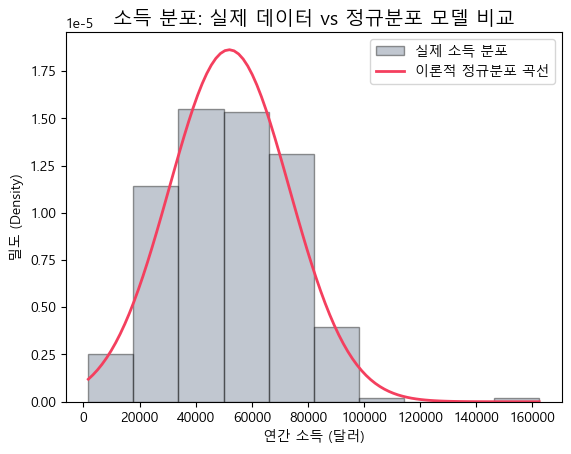

In [ ]:
# TODO 2-3(b): 실제 데이터의 히스토그램 + 정규 PDF 겹쳐 그리기
income_data = df['Income']
x_range = np.linspace(income_data.min(), income_data.max(), 100)

income_pdf = stats.norm.pdf(x_range, mu_income, std_income) #소득에 따른 이론적인 확률밀도값을 동시에 구하기 위해 파라미터로 x_range 추가

# 실제 데이터
plt.hist(income_data, alpha=0.4, density=True, color=COLORS['slate'], label='실제 소득 분포', edgecolor='black')

# 분석 모델
plt.plot(x_range, income_pdf, color=COLORS['rose'], linewidth=2, label='이론적 정규분포 곡선')

plt.title('소득 분포: 실제 데이터 vs 정규분포 모델 비교', fontsize=14)
plt.xlabel('연간 소득 (달러)')
plt.ylabel('밀도 (Density)')
plt.legend()
plt.show()

In [63]:
# TODO 2-3(c): 실무 시나리오 — VIP(상위 5%) 기준선 + 할인 대상(하위 10%) 기준선
# VIP(상위 5%) 기준선
vip_threshold = stats.norm.ppf(0.95, mu_income, std_income)

# 할인 대상(하위 10%) 기준선
discount_threshold = stats.norm.ppf(0.10, mu_income, std_income)

# 분석결과
print(f"--- 정규분포 모델 기반 마케팅 기준안 ---")
print(f"VIP 고객 기준선 (상위 5%): 연 소득 {np.ceil(vip_threshold):,.0f} 달러 이상")
print(f"할인 대상 기준선 (하위 10%): 연 소득 {np.floor(discount_threshold):,.0f} 달러 이하")

--- 정규분포 모델 기반 마케팅 기준안 ---
VIP 고객 기준선 (상위 5%): 연 소득 87,172 달러 이상
할인 대상 기준선 (하위 10%): 연 소득 24,512 달러 이하


---
## Part 3: 추정과 가설검정 — "고소득 고객과 저소득 고객의 소비는 다른가?"

신뢰구간과 가설검정을 통해 고객 그룹 간 차이를 통계적으로 검증합니다.

### 문제 3-1. 신뢰구간 추정

- **(a)** Total_Spending 평균의 90%, 95%, 99% 신뢰구간을 계산하세요.
- **(b)** Income_Group별 95% CI를 계산하고 오차막대 그래프로 비교하세요.

CI = [x̄ - t × SE, x̄ + t × SE] (SE = s / √n)

In [65]:
# TODO 3-1(a): Total_Spending 평균의 신뢰구간 (90%, 95%, 99%)
# CI = x̄ ± t(α/2, n-1) × SE

spending_data = df['Total_Spending']
n = len(spending_data)
mu_spending = spending_data.mean()
SE_spending = np.std(spending_data, ddof=1) / np.sqrt(n) # 표준오차

# CI
ci_90 = stats.t.interval(0.90, df=n-1, loc=mu_spending, scale=SE_spending)
ci_95 = stats.t.interval(0.95, df=n-1, loc=mu_spending, scale=SE_spending)
ci_99 = stats.t.interval(0.99, df=n-1, loc=mu_spending, scale=SE_spending)

# 결과 출력
print(f"--- Total_Spending 평균 신뢰구간 추정 ---")
print(f"샘플 평균(x̄): {mu_spending:.2f}")
print(f"샘플 크기(n): {n}\n")

print(f"1. 90% 신뢰구간: [{ci_90[0]:.2f}, {ci_90[1]:.2f}]")
print(f"   (구간 너비: {ci_90[1] - ci_90[0]:.2f})")

print(f"2. 95% 신뢰구간: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")
print(f"   (구간 너비: {ci_95[1] - ci_95[0]:.2f})")

print(f"3. 99% 신뢰구간: [{ci_99[0]:.2f}, {ci_99[1]:.2f}]")
print(f"   (구간 너비: {ci_99[1] - ci_99[0]:.2f})")

--- Total_Spending 평균 신뢰구간 추정 ---
샘플 평균(x̄): 605.99
샘플 크기(n): 2236

1. 90% 신뢰구간: [585.04, 626.93]
   (구간 너비: 41.89)
2. 95% 신뢰구간: [581.03, 630.95]
   (구간 너비: 49.92)
3. 99% 신뢰구간: [573.17, 638.80]
   (구간 너비: 65.63)


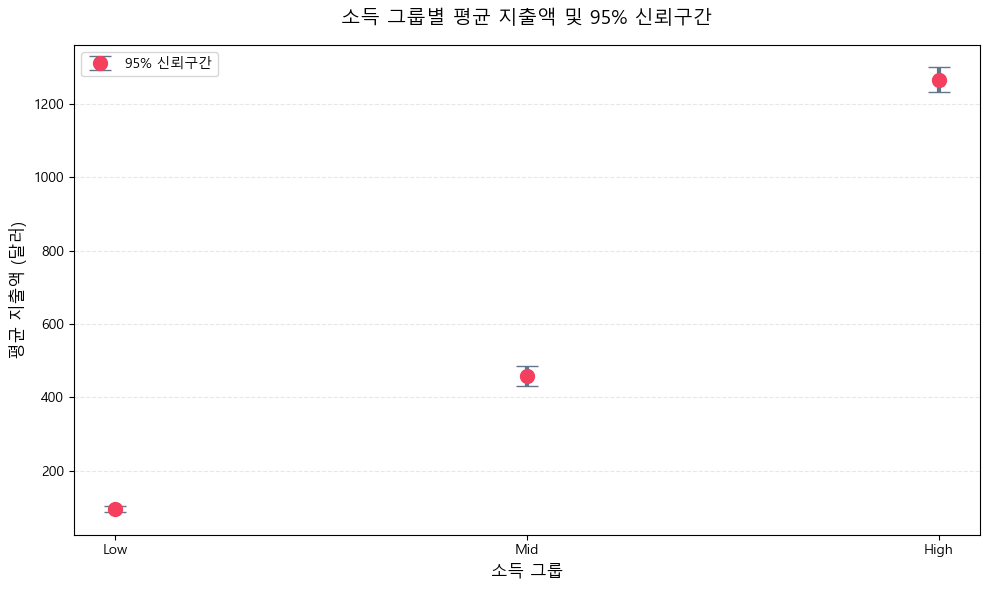

In [68]:
# TODO 3-1(b): Income_Group별 95% CI 계산 + 오차막대 그래프
# 소득 그룹별로 평균, 표준편차, 데이터 개수
group_stats = df.groupby('Income_Group')['Total_Spending'].agg(['mean', 'std', 'count'])

# 95% 신뢰구간의 오차 범위(Margin of Error)
confidence_level = 0.95

# 표준오차 (SE = s / sqrt(n))
group_stats['se'] = group_stats['std'] / np.sqrt(group_stats['count'])

# t-값 계산 (자유도 = n - 1)
group_stats['t_value'] = stats.t.ppf((1 + confidence_level) / 2, group_stats['count'] - 1)

# 오차 범위 (d = t * SE)
group_stats['error'] = group_stats['t_value'] * group_stats['se']

# 3. 시각화: 오차막대 그래프 (Error Bar)
plt.figure(figsize=(10, 6))

ordered_index = ['Low', 'Mid', 'High']
group_stats = group_stats.reindex(ordered_index)

plt.errorbar(x=group_stats.index, y=group_stats['mean'], yerr=group_stats['error'],
             fmt='o', color=COLORS['rose'], ecolor=COLORS['slate'],
             elinewidth=3, capsize=8, markersize=10, label='95% 신뢰구간')

plt.title('소득 그룹별 평균 지출액 및 95% 신뢰구간', fontsize=14, pad=15)
plt.xlabel('소득 그룹', fontsize=12)
plt.ylabel('평균 지출액 (달러)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

### 문제 3-2. 독립표본 t-검정 (Welch's t-test)

**가설**: 자녀가 없는 고객의 총 소비가 자녀가 있는 고객과 다른가?

- H₀: μ_무자녀 = μ_유자녀
- H₁: μ_무자녀 ≠ μ_유자녀

Cohen's d 해석 기준: |d| < 0.5 작은, 0.5~0.8 중간, > 0.8 큰 효과

In [71]:
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력
t_stat, p_value = stats.ttest_ind(no_child, yes_child, equal_var=False)

# 효과 크기를 구하는 함수 정의
def cohens_d_ind(group1, group2):
    """Cohen's d — 독립표본: d = |x̄₁ - x̄₂| / s_pooled"""
    n1, n2 = len(group1), len(group2)
    var1 = np.var(group1, ddof=1)
    var2 = np.var(group2, ddof=1)
    s_pooled = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2)) # 합동 분산 
    return abs(np.mean(group1) - np.mean(group2)) / s_pooled

# 효과크기
cohens_d_value = cohens_d_ind(no_child, yes_child)

# 결과
print(f"--- 독립표본 t-검정 결과 (자녀 유무) ---")
print(f"t-통계량 (t-statistic): {t_stat:.4f}")
print(f"p-값 (p-value): {p_value:.4e}")
print(f"효과크기: {cohens_d_value:.4f}")

print("\n--- [효과크기 분석]] ---")
if cohens_d_value < 0.5:
    effect_size = '작은'
elif cohens_d_value < 0.8:
    effect_size = '중간인'    
else:
    effect_size = '큰'   
    
print(f"효과크기가 {cohens_d_value:.2f}로 효과크기는 {effect_size} 편입니다.")     

--- 독립표본 t-검정 결과 (자녀 유무) ---
t-통계량 (t-statistic): 24.9889
p-값 (p-value): 6.3212e-105
효과크기: 1.3599

--- [효과크기 분석]] ---
효과크기가 1.36로 효과크기는 큰 편입니다.


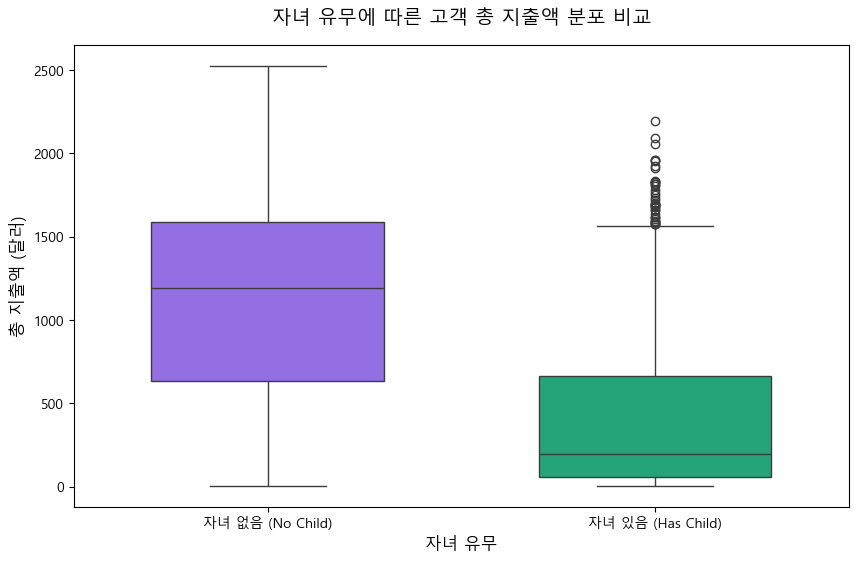

In [76]:
# TODO 3-2(c): 박스플롯 비교 시각화
plt.figure(figsize=(10, 6))

# 2. 박스플롯 그리기
# x축은 자녀 유무(Has_Children), y축은 총 지출액(Total_Spending)
sns.boxplot(data=df, x='Has_Children', y='Total_Spending', 
            palette=[COLORS['violet'], COLORS['emerald']], # 우리가 정한 컬러셋 활용
            width=0.6)

plt.title('자녀 유무에 따른 고객 총 지출액 분포 비교', fontsize=14, pad=15)
plt.xlabel('자녀 유무', fontsize=12)
plt.ylabel('총 지출액 (달러)', fontsize=12)

plt.xticks([0, 1], ['자녀 없음 (No Child)', '자녀 있음 (Has Child)'])

plt.show()

### 문제 3-3. 대응표본 t-검정

같은 고객의 **와인 소비**(`MntWines`)와 **육류 소비**(`MntMeatProducts`)를 비교합니다.

- H₀: μ_Wine = μ_Meat (차이 = 0)
- H₁: μ_Wine ≠ μ_Meat

In [77]:
wines = df['MntWines']
meat = df['MntMeatProducts']

# TODO 3-3: 차이 계산 + 대응표본 t-검정 + Cohen's d + 결과 출력
# 차이 계산
diff = wines - meat

# 대응표본 t-검정
t_stat, p_val = stats.ttest_rel(wines, meat)

# Cohen's d
cohens_d_rel = np.mean(diff) / np.std(diff, ddof=1)

# 결과 출력
print(f"--- 대응표본 t-검정 결과 (와인 vs 육류) ---")
print(f"차이의 평균 (Wine - Meat): {diff.mean():.2f}")
print(f"t-통계량: {t_stat:.4f}")
print(f"p-값: {p_val:.4e}")
print(f"Cohen's d (Paired): {abs(cohens_d_rel):.4f}")

--- 대응표본 t-검정 결과 (와인 vs 육류) ---
차이의 평균 (Wine - Meat): 137.14
t-통계량: 23.0929
p-값: 5.3919e-106
Cohen's d (Paired): 0.4884


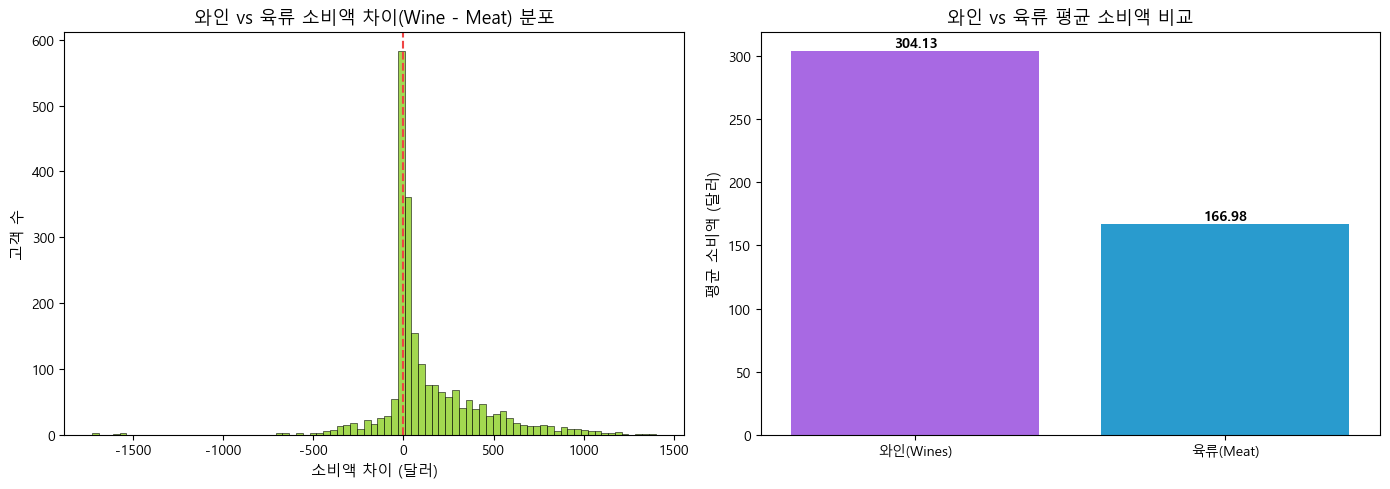

In [89]:
# TODO 3-3(b): (1) 대응 차이 히스토그램 (2) 카테고리별 평균 비교 막대그래프
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (1) 대응 차이 히스토그램
sns.histplot(diff, color=COLORS['lime'], ax=axes[0])
axes[0].axvline(0, color=COLORS['red'], linestyle='--', linewidth=1.5)
axes[0].set_title('와인 vs 육류 소비액 차이(Wine - Meat) 분포', fontsize=13)
axes[0].set_xlabel('소비액 차이 (달러)', fontsize=11)
axes[0].set_ylabel('고객 수', fontsize=11)

# (2) 카테고리별 평균 비교 막대그래프
categories = ['와인(Wines)', '육류(Meat)']
means = [wines.mean(), meat.mean()]
sns.barplot(x=categories, y=means, 
            palette=[COLORS['purple'], COLORS['sky']], ax=axes[1])

# 막대 위에 평균값 추가
for i, v in enumerate(means): # i번째 위치에 있는 v라는 값(여기서는 평균)을 꺼냄
    axes[1].text(i, v + 3, f'{v:.2f}', ha='center', fontweight='bold')

axes[1].set_title('와인 vs 육류 평균 소비액 비교', fontsize=13)
axes[1].set_ylabel('평균 소비액 (달러)', fontsize=11)

plt.tight_layout()
plt.show()

### 문제 3-4. 검정력 분석

- **(a)** 문제 3-2의 효과 크기와 표본 크기를 사용하여 검정력(Power)을 계산하세요.
- **(b)** 작은 효과(d=0.2)를 탐지하기 위해 필요한 그룹당 표본 크기를 구하세요.

In [143]:
power_analysis = TTestIndPower()

# TODO 3-4(a): 문제 3-2 기준 검정력 계산🔴🔴🔴🔴🔴🔴
n1 = len(no_child)
n2 = len(yes_child)
ratio_n = n2 / n1 # 두 집단의 크기 비율

alpha=0.05 # 유의수준을 5%로 가정함

def cal_for_power(cohens_d, n, ratio, alpha):

    result = power_analysis.solve_power(effect_size=abs(cohens_d), 
                                        nobs1=n, 
                                        ratio=ratio, 
                                        alpha=alpha,
                                        alternative='two-sided')
    return result


power = cal_for_power(cohens_d_value, n1, ratio_n, alpha)

print(f"--- 문제 3-2 기준 검정력 계산 ---")
print(f"검정력 (Power): {power*100:.1f}") # nan
# nan값이 나옴 -> n이 커서 nan이 나오는 경우 1.0으로 처리할 수도 있다고 함
print(f"\n<표본크기>")
print(f"아이가 없는 그룹(no_child): {n1}")
print(f"아이가 있는 그룹(yes_child): {n2}")
print(f"표본크기(n)가 너무 크면 nan으로 출력되는 경우가 있는데, 이를 1.0으로 처리할 수도 있다고 한다.")

# TODO 3-4(b): 작은 효과(d=0.2) 탐지에 필요한 표본 크기 산정
# 두 집단의 인원수가 동일하다고 가정함
require_n = power_analysis.solve_power(
    effect_size=0.2,
    alpha=alpha,
    power=0.8,    # 목표 검정력 80%
    ratio=1.0,    # 1:1 비율 가정
    alternative='two-sided'
)

print(f"\n--- 향후 실험 설계 가이드 (두 집단의 크기는 1:1 비율이라 가정) ---")
print(f"미세한 차이(d=0.2)를 찾기 위한 그룹당 최소 인원: {np.ceil(require_n):.0f}명")

--- 문제 3-2 기준 검정력 계산 ---
검정력 (Power): nan

<표본크기>
아이가 없는 그룹(no_child): 637
아이가 있는 그룹(yes_child): 1599
표본크기(n)가 너무 크면 nan으로 출력되는 경우가 있는데, 이를 1.0으로 처리할 수도 있다고 한다.

--- 향후 실험 설계 가이드 (두 집단의 크기는 1:1 비율이라 가정) ---
미세한 차이(d=0.2)를 찾기 위한 그룹당 최소 인원: 394명


---
## Part 4: 고급 검정 — "교육, 결혼, 캠페인 반응의 관계는?"

정규성 검정을 바탕으로 적절한 검정 방법을 선택하고,
범주형 변수 간 관계를 분석합니다.

### 문제 4-1. 정규성 + 등분산 검정

Education_Group별 Total_Spending의 정규성을 Shapiro-Wilk 검정과 Q-Q Plot으로 확인하세요.
정규성이 기각되더라도, 표본이 충분히 크면(n ≥ 30) 중심극한정리(CLT)에 의해
ANOVA가 여전히 강건(robust)합니다. 각 그룹의 표본 크기도 함께 확인하세요.

⚠️ **등분산성 위반은 CLT와 무관합니다** — 표본이 아무리 커도 해결되지 않습니다.
Levene 검정으로 등분산 가정을 확인하고, 위반 시 Welch's ANOVA를 사용합니다.

In [147]:
edu_groups = ['Undergraduate', 'Graduate', 'Postgraduate']

# TODO 4-1(a): Shapiro-Wilk 검정 (각 그룹별)
print("--- 학력 그룹별 정규성 검정 (Shapiro-Wilk) ---")
for edu in edu_groups:
    group_spending = df[df['Education_Group'] == edu]['Total_Spending']
    
    # Shapiro-Wilk 검정
    shapiro_stst, shapiro_p = stats.shapiro(group_spending)
    n = len(group_spending)
    
    print(f"그룹명: {edu} | 표본의 크기는 {n:,}이고, p-value는 {shapiro_p:.2e}") # p-value에는 지수표기법 사용

# TODO 4-1(b): Levene 등분산 검정 → use_welch = True/False 설정
# Education_Group에 따른 Total_Spending 데이터 추출
group_unders_spending = df[df['Education_Group'] == 'Undergraduate']['Total_Spending']
group_graduates_spending = df[df['Education_Group'] == 'Graduate']['Total_Spending']
group_posts_spending = df[df['Education_Group'] == 'Postgraduate']['Total_Spending']

# 등분산 검정 수행 (기본값: median)
levene_stat, levene_p = stats.levene(group_unders_spending, group_graduates_spending, group_posts_spending)

use_welch = True if levene_p < alpha else False

print(f"\n--- 등분산 검정 결과 (Levene's Test) ---")
print(f"통계량: {levene_stat:.4f} | p-value: {levene_p:.2e}")
print(f"등분산성 만족 여부: {"등분산성을 위반하므로 Welch's ANOVA 사용" if use_welch else '등분산성을 만족하므로 One-way ANOVA 사용'}")

--- 학력 그룹별 정규성 검정 (Shapiro-Wilk) ---
그룹명: Undergraduate | 표본의 크기는 255이고, p-value는 5.54e-19
그룹명: Graduate | 표본의 크기는 1,126이고, p-value는 3.56e-29
그룹명: Postgraduate | 표본의 크기는 855이고, p-value는 1.78e-25

--- 등분산 검정 결과 (Levene's Test) ---
통계량: 13.2893 | p-value: 1.83e-06
등분산성 만족 여부: 등분산성을 위반하므로 Welch's ANOVA 사용


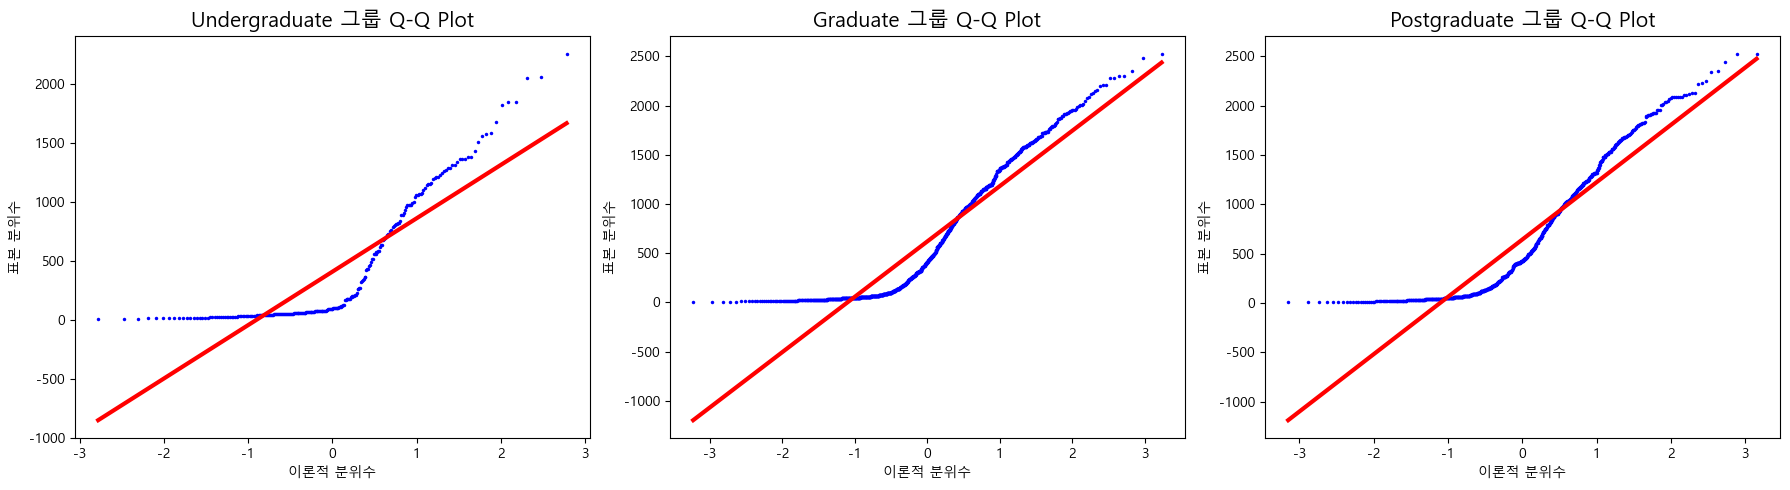

In [151]:
# TODO 4-1(b): Q-Q Plot (1×3 서브플롯)
spending_data = [group_unders_spending, group_graduates_spending, group_posts_spending]
edu_names = ['Undergraduate', 'Graduate', 'Postgraduate']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, data in enumerate(spending_data):
    # 추출된 개별 변수를 사용하여 Q-Q Plot 생성
    stats.probplot(data, dist="norm", plot=axes[i])

    # 그래프 객체 가져오기
    # get_lines()[0]은 파란 점(표본), get_lines()[1]은 빨간 선(이론적 회귀선)입니다.
    blue_dots = axes[i].get_lines()[0]
    red_line = axes[i].get_lines()[1]
    
    # 스타일 수정
    # 빨간 선 두께 높이기
    red_line.set_linewidth(3) 
    
    # 파란 점 크기 줄이기 (점들이 모여 형성하는 선의 두께가 얇아 보임)
    blue_dots.set_markersize(2.5)
    blue_dots.set_markeredgewidth(0) # 점의 테두리를 없애 더 얇게 표현
    
    # 한글 제목 및 축 설정
    axes[i].set_title(f'{edu_names[i]} 그룹 Q-Q Plot', fontsize=15)
    axes[i].set_xlabel('이론적 분위수', fontsize=10)
    axes[i].set_ylabel('표본 분위수', fontsize=10)

plt.tight_layout()
plt.show()

### 문제 4-2. ANOVA + 사후검정

문제 4-1의 정규성/등분산 검정 결과에 따라 적절한 검정을 수행합니다.

- 등분산 만족 → One-way ANOVA + **Tukey HSD** + Cohen's d
- 등분산 위반 → Welch's ANOVA + **Games-Howell** (`pg.pairwise_gameshowell()`) + Hedges' g
- 참고로 비모수 검정(Kruskal-Wallis)도 병행하여 결과의 일관성을 확인하세요.
- 효과 크기: η² + ω² (기준: 0.01 작은, 0.06 중간, 0.14 큰)
- 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

In [160]:
group_data = {g: df[df['Education_Group'] == g]['Total_Spending'].values for g in edu_groups}

# TODO 4-2(a): use_welch에 따라 ANOVA / Welch's ANOVA 수행 (Kruskal-Wallis도 병행)
print(f"--- [4-2(a)] 학력 그룹별 차이 검정 (use_welch: {use_welch}) ---")
if use_welch:
    # Welch's ANOVA
    anova_res = pg.welch_anova(data=df, dv='Total_Spending', between='Education_Group')
    f_value = anova_res['F'].values[0]
    p_value = anova_res['p-unc'].values[0]
    used_mathod = "Welch's ANOVA"
else:
    # one-way ANOVA
    anova_res = pg.anova(data=df, dv='Total_Spending', between='Education_Group', detailed=True)
    f_value = anova_res['F'].values[0]
    p_value = anova_res['p-unc'].values[0]
    used_mathod = "one-way ANOVA"

# Kruskal-Wallis 검정    
k_stat, p_k = stats.kruskal(group_unders_spending, group_graduates_spending, group_posts_spending)

print(f"- {used_mathod} 결과")
print(f"F-statistic: {f_value:.4f} | p-value: {p_value:.2e}")

print(f"\n- Kruskal-Wallis 결과")
print(f"H-statistic: {k_stat:.4f} | p-value: {p_k:.2e}")    

# TODO 4-2(b): η² + ω² 계산
# ω²를 계산하기 위한 값인 평균제곱(MS), 제곱합(SS)를 얻기 위해 pg.anova 사용
anova_detailed = pg.anova(data=df, dv='Total_Spending', between='Education_Group', detailed=True)
# anova_detailed의 구성
#   Source	             SS	               DF	        MS	                 F	              p-unc        np2
#0	Education_Group	1.109189e+07	       2	    5.545944e+06	     15.508841	     2.046193e-07	  0.0137
#1	Within	        7.985182e+08	      2233	    3.575989e+05	       NaN	             NaN	       NaN

ss_between = anova_detailed['SS'].values[0]
ss_within = anova_detailed['SS'].values[1]
total_ss = ss_between + ss_within

ms_within = anova_detailed['MS'].values[1]
dof = anova_detailed['DF'].values[0]

# η² = SS_between / SS_total
eta_sq = ss_between / total_ss

# ω² = (SS_between - (자유도)*MS_within) / (SS_total + MS_within)
omega_sq = (ss_between - dof * ms_within) / (total_ss + ms_within)

print(f"\n--- [4-2(b)] 효과 크기(Effect Size) 계산 결과 ---")
print(f"η²: {eta_sq:.4f}")
print(f"ω²: {omega_sq:.4f}")
print(f"소표본에서 과대추정되는 경향이 있는 효과크기인 η²대신 편향이 보정된 효과크기인 ω²를 사용할 것입니다.")

def interpret_effect_size(value):
    if value >= 0.14:
        return "큰 편입니다."
    elif value >= 0.08:
        return "중간인 편입니다."
    elif value >= 0.01:
        return "작은 편입니다."
    
print(f"따라서 학력과 총 지출금액 간의 효과크기는 {interpret_effect_size(omega_sq)}")    

--- [4-2(a)] 학력 그룹별 차이 검정 (use_welch: True) ---
- Welch's ANOVA 결과
F-statistic: 19.8174 | p-value: 4.10e-09

- Kruskal-Wallis 결과
H-statistic: 36.6133 | p-value: 1.12e-08

--- [4-2(b)] 효과 크기(Effect Size) 계산 결과 ---
η²: 0.0137
ω²: 0.0128
소표본에서 과대추정되는 경향이 있는 효과크기인 η²대신 편향이 보정된 효과크기인 ω²를 사용할 것입니다.
따라서 학력과 총 지출금액 간의 효과크기는 작은 편입니다.


In [170]:
# TODO 4-2(c): 사후검정 수행 + 해석 + 쌍별 효과크기
# 등분산 만족 → Tukey HSD + Cohen's d
# 등분산 위반 → Games-Howell (pg.pairwise_gameshowell) + Hedges' g
print(f"--- [4-2(c)] 사후검정 결과 (등분산 만족 여부: {"만족하지 않음" if use_welch else "만족함"}) ---")

# 사후검정 수행 + 쌍별 효과크기
if use_welch:
    # Games-Howell
    posthoc = pg.pairwise_gameshowell(data=df, dv='Total_Spending', between='Education_Group',effsize='hedges')
    posthoc_method = "Games-Howell (Hedges' g)"
    p_column_name = 'pval'
    effect_size_column_name = 'hedges'
else:
    # Tukey HSD
    posthoc = pg.pairwise_tukey(data=df, dv='Total_Spending', between='Education_Group',effsize='cohen')
    posthoc_method = "Tukey HSD (Cohen's d)"  
    p_column_name = 'p-tukey'
    effect_size_column_name = 'cohen'   
    
# 해석
print(f"{posthoc_method} 사후검정 결과 분석 수행 결과")
def get_effect_size_label(value):
    abs_value = abs(value)
    if abs_value >= 0.8:
        return '큰 편이다.'       
    elif abs_value >= 0.5:
        return '중간인 편이다.'
    elif abs_value >= 0.2:
        return '작은 편이다.'
    else:
        return '매우 작은 편이다.'      

for inx, row in posthoc.iterrows():
    # 각각의 비교 대상과 p-value 추출
    pair_group = f"{row['A']} vs {row['B']}"
    p_value = row[p_column_name]
    effect_size_value = row[effect_size_column_name]
    
    # 통계적 유의성 판단
    # 유의수준은 0.05로 가정
    is_usable = "통계적으로 유의미한 차이가 있음" if p_value < 0.05 else "통계적으로 유의미한 차이가 없음"
    
    es_lable = get_effect_size_label(effect_size_value)
    
    print(f"\n- {inx+1}번째 비교: {pair_group}")
    print(f"P-value가 {p_value:.2e}이므로 {is_usable}")
    print(f"효과크기({effect_size_column_name})가 {effect_size_value:.4f}이므로 {es_lable}")     

--- [4-2(c)] 사후검정 결과 (등분산 만족 여부: 만족하지 않음) ---
Games-Howell (Hedges' g) 사후검정 결과 분석 수행 결과

- 1번째 비교: Graduate vs Postgraduate
P-value가 6.52e-01이므로 통계적으로 유의미한 차이가 없음
효과크기(hedges)가 -0.0401이므로 매우 작은 편이다.

- 2번째 비교: Graduate vs Undergraduate
P-value가 8.92e-08이므로 통계적으로 유의미한 차이가 있음
효과크기(hedges)가 0.3557이므로 작은 편이다.

- 3번째 비교: Postgraduate vs Undergraduate
P-value가 9.58e-09이므로 통계적으로 유의미한 차이가 있음
효과크기(hedges)가 0.3896이므로 작은 편이다.


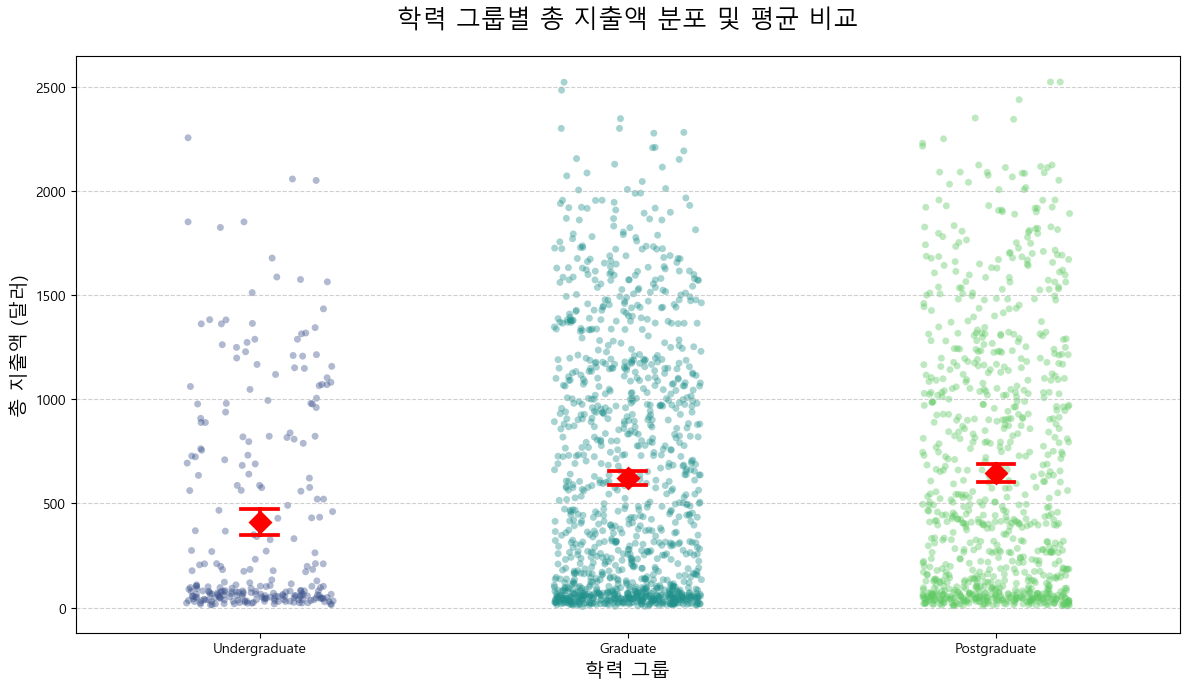

In [173]:
# TODO 4-2(d): 시각화 — 그룹별 개별 데이터 산점도 + 평균 다이아몬드

plt.figure(figsize=(12, 7))

# 개별 데이터 포인트 산점도 (Strip Plot)
# 각 학력 그룹에 속하는 고객들의 실제 지출액을 점으로 표시하여 분포를 시각화
sns.stripplot(x='Education_Group', y='Total_Spending', data=df, 
              order=edu_names,
              palette='viridis', alpha=0.4, jitter=0.2, zorder=1) # zorder를 사용해 평균 다이아몬드 및 신뢰 구간 플롯 뒤에 배치

# 평균 다이아몬드 및 신뢰 구간
# capsize로 신뢰구간 막대의 끝에 캡을 추가하여 가독성을 높임
sns.pointplot(x='Education_Group', y='Total_Spending', data=df,
              order=edu_names,
              color='red', marker='D', markersize=10, linestyle='', capsize=0.1, zorder=2) # zorder를 사용해 strip plot 위에 배치

plt.title('학력 그룹별 총 지출액 분포 및 평균 비교', fontsize=18, pad=20)
plt.xlabel('학력 그룹', fontsize=14)
plt.ylabel('총 지출액 (달러)', fontsize=14)

# 그리드 라인 추가 (가독성 향상)
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

### 문제 4-3. 카이제곱 독립성 검정

**가설**: 결혼 상태(Marital_Group)와 캠페인 반응(Campaign_Response)은 독립인가?

- H₀: Marital_Group과 Campaign_Response는 독립이다.
- H₁: 두 변수는 독립이 아니다.

- 효과크기: φ (phi) = √(χ² / n) (기준: 0.1 작은, 0.3 중간, 0.5 큰)
- 오즈비(Odds Ratio): OR = (a×d) / (b×c), 95% CI = exp(ln(OR) ± 1.96 × SE)

> ⚠️ Cochran 규칙: 기대빈도 < 5인 셀이 전체의 20% 초과 시 Fisher 정확검정 필요

In [181]:
crosstab_no_margin = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])

# TODO 4-3(a): 카이제곱 검정 수행 + Cochran 규칙 확인
print(f"--- [4-3(a)] 카이제곱 검정 수행 + Cochran 규칙 확인 ---")
# 카이제곱 독립성 검정
chi2_stat, p_chi2, dof_chi2, expected_value_chi2 = stats.chi2_contingency(crosstab_no_margin)

# Cochran 규칙 확인
num_of_cells = expected_value_chi2.size
under5_cells_cnt = (expected_value_chi2 < 5).sum()
under5_cells_ratio = under5_cells_cnt / num_of_cells
under1_cells_cnt =(expected_value_chi2 < 1).sum()

if (under5_cells_ratio > 20) or (under1_cells_cnt > 0):
    print("Cochran 규칙을 위반하므로 Fisher-Freeman-Halton 검정을 활용하는 것을 추천합니다.")
else:
    print("Cochran 규칙을 만족하므로 카이제곱 독립성 검정을 활용합니다.")        


--- [4-3(a)] 카이제곱 검정 수행 + Cochran 규칙 확인 ---
Cochran 규칙을 만족하므로 카이제곱 독립성 검정을 활용합니다.


In [ ]:
print(f"crosstab_no_margin의 크기: {crosstab_no_margin.shape}")

crosstab_no_margin의 크기: (2, 2)


In [182]:
# TODO 4-3(b): φ (phi) 계산
n = len(df)

# 보정되지 않은 카이제곱 통계량 계산
chi2_stat_real = stats.chi2_contingency(crosstab_no_margin, correction=False)[0]

phi_value = np.sqrt(chi2_stat_real/n)

print(f"--- [4-3(b)] 효과 크기 (Phi) ---")
print(f"Phi (φ): {phi_value:.4f}")

--- [4-3(b)] 효과 크기 (Phi) ---
Phi (φ): 0.0653


In [188]:
# TODO 4-3(c): 오즈비(Odds Ratio) + 95% CI 계산
# 각 셀의 빈도 추출
a = crosstab_no_margin.iloc[0, 0] # 그룹1 & 미응답(0)
b = crosstab_no_margin.iloc[0, 1] # 그룹1 & 응답(1)
c = crosstab_no_margin.iloc[1, 0] # 그룹2 & 미응답(0)
d = crosstab_no_margin.iloc[1, 1] # 그룹2 & 응답(1)

# 오즈비(Odds Ratio)
# 범위: 0 ~ 양의 무한대
# 자연로그를 취해 모든 구간에서 0을 중심으로 대칭이 되도록 만들어 신뢰구간 계산을 용이하게 하려고 -> 계산이 종료되면 다시 np.exp()를 취할 예정
odds_ratio = (a * d) / (b * c)

log_odds_ratio = np.log(odds_ratio) # 자연로그를 취한 오즈비

# ln(odds_ratio)의 표준오차
# 공식: np.sqrt(1/a + 1/b + 1/c + 1/d) --> a, b, c, d는 2x2 교차표의 각 셀에 들어있는 빈도(관측수)  
# 빈도가 분모에 위치한다는 것은, 해당 칸의 데이터가 많을수록 전체 오차(SE)가 줄어든다는 것을 의미함
se_log_odds_ratio = np.sqrt(1/a + 1/b + 1/c + 1/d)

# 95% CI 계산
z_score = 1.96

# 공식: CI = np.exp(np.log(odds_ratio) +- z-score * SE)
ci_low = np.exp(log_odds_ratio - z_score * se_log_odds_ratio)
ci_high = np.exp(log_odds_ratio + z_score * se_log_odds_ratio)

print(f"--- [4-3(c)] 오즈비(Odds Ratio) 분석 결과 ---")
print(f"오즈비 (Odds Ratio): {odds_ratio:.4f}")
print(f"95% 신뢰구간 (CI): [{ci_low:.4f}, {ci_high:.4f}]")

print("\n[결과 해석]")
if ci_low > 1 or ci_high < 1:
    print("해석: 신뢰구간이 1을 포함하지 않으므로, 두 그룹 간 응답률 차이는 통계적으로 유의미하다.")
else:
    print("해석: 신뢰구간이 1을 포함하므로, 두 그룹 간 응답률 차이는 통계적으로 유의미하지 않을 가능성이 있다.")    

--- [4-3(c)] 오즈비(Odds Ratio) 분석 결과 ---
오즈비 (Odds Ratio): 0.7396
95% 신뢰구간 (CI): [0.6105, 0.8959]

[결과 해석]
해석: 신뢰구간이 1을 포함하지 않으므로, 두 그룹 간 응답률 차이는 통계적으로 유의미하다.


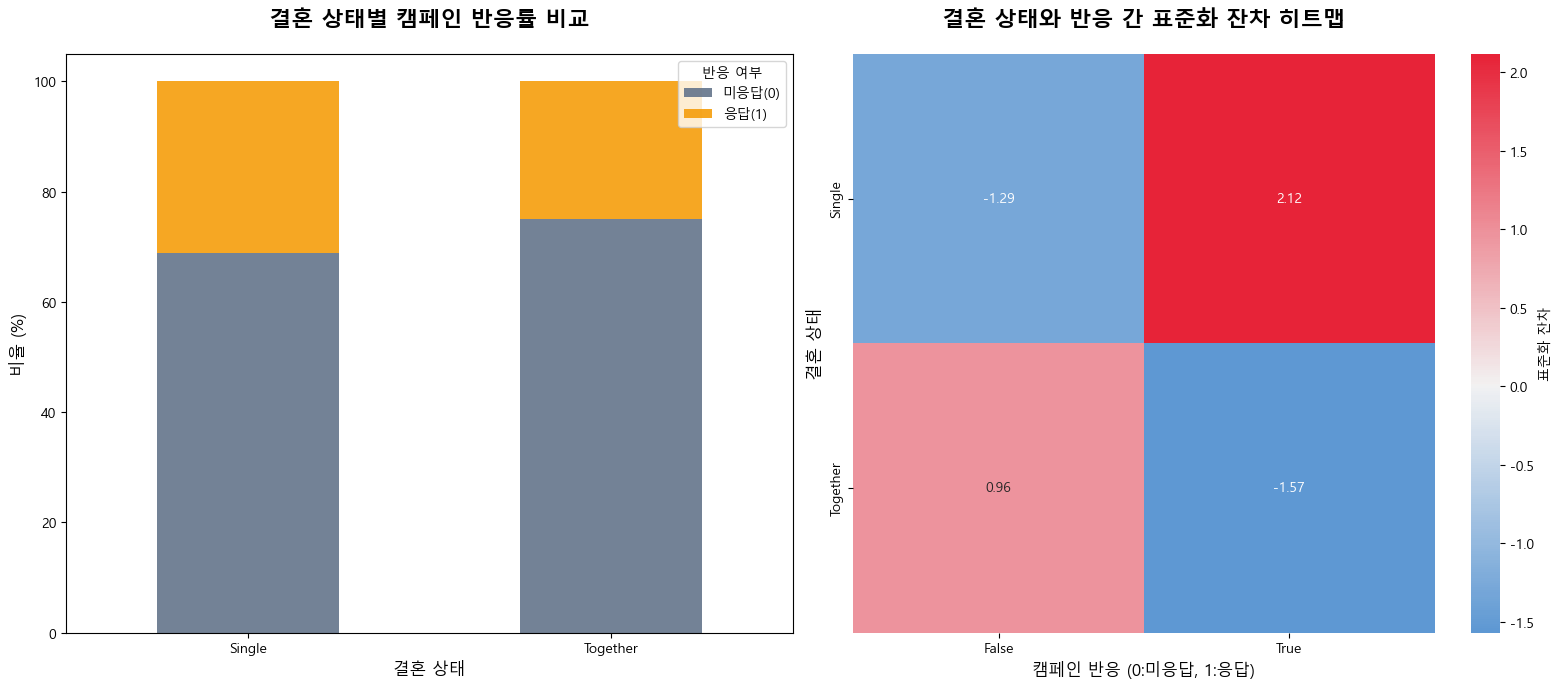

In [191]:
# TODO 4-3(d): (1) 결혼 상태별 반응률 막대그래프 (2) 표준화 잔차 히트맵

fig, ax = plt.subplots(1, 2, figsize=(16, 7))

# 결혼 상태별 반응률 누적막대그래프
# 미응답(0)은 무채색 계열인 'slate', 응답(1)은 강조색인 'indigo' 사용
response_rate = crosstab_no_margin.div(crosstab_no_margin.sum(axis=1), axis=0) * 100

response_rate.plot(kind='bar', stacked=True, ax=ax[0], 
                   color=[COLORS['slate'], COLORS['amber']], alpha=0.9, rot=0)

ax[0].set_title('결혼 상태별 캠페인 반응률 비교', fontsize=16, pad=20, fontweight='bold')
ax[0].set_xlabel('결혼 상태', fontsize=12)
ax[0].set_ylabel('비율 (%)', fontsize=12)
ax[0].legend(title='반응 여부', labels=['미응답(0)', '응답(1)'], loc='upper right')

# 표준화 잔차 히트맵
# 표준화 잔차 공식: (관측값 - 기대값) / 표준편차
# 카이제곱 검정에서 각 셀의 빈도는 **포아송 분포(Poisson Distribution)**를 따른다고 가정한다고 함 -> 기대값(평균) = E = 분산
residuals = (crosstab_no_margin - expected_value_chi2) / np.sqrt(expected_value_chi2)

# 발산형 컬러맵 생성 (blue -> slate -> rose)
cmap = sns.diverging_palette(250, 10, s=90, l=50, as_cmap=True) 

sns.heatmap(residuals, annot=True, fmt=".2f", cmap=cmap, center=0, 
            cbar_kws={'label': '표준화 잔차'}, ax=ax[1])

ax[1].set_title('결혼 상태와 반응 간 표준화 잔차 히트맵', fontsize=16, pad=20, fontweight='bold')
ax[1].set_xlabel('캠페인 반응 (0:미응답, 1:응답)', fontsize=12)
ax[1].set_ylabel('결혼 상태', fontsize=12)


plt.tight_layout()
plt.show()

### 문제 4-4. 적합도 검정

3개 구매 채널(Web, Catalog, Store)의 총 구매 비율이 균등하게 분포하는지 검정합니다.

- H₀: 세 채널의 구매 비율이 동일하다 (1/3 : 1/3 : 1/3)
- H₁: 세 채널의 구매 비율이 동일하지 않다

Cohen's w = √(Σ(p_obs - p_exp)² / p_exp)

In [204]:
channel_totals = df[purchase_cols].sum()
channel_names = ['Web', 'Catalog', 'Store']
observed = channel_totals.values

# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정
# 기대빈도
# 모든 채널의 구매 비율이 동일하다고 가정하므로 (Total / 3) = 기대빈도
total_purchases = observed.sum()
expected = np.array([total_purchases / len(observed)] * len(observed))

# 카이제곱 적합도 검정
chi2_value, p_val_chi2 = stats.chisquare(observed, expected)

print(f"--- [4-4(a)] 적합도 검정(Goodness-of-Fit Test) 결과 ---")
print(f"관측 빈도 (Web, Catalog, Store): {observed}")
print(f"기대 빈도 (균등 분포): {expected.round(2)}")
print(f"카이제곱 통계량: {chi2_value:.2f}")

if p_val_chi2 < 0.001:
    print("p-value는 0.001보다 작습니다.")
else:
    print(f"{p_val_chi2:.4f}")

--- [4-4(a)] 적합도 검정(Goodness-of-Fit Test) 결과 ---
관측 빈도 (Web, Catalog, Store): [ 9140  5955 12959]
기대 빈도 (균등 분포): [9351.33 9351.33 9351.33]
카이제곱 통계량: 2630.11
p-value는 0.001보다 작습니다.


In [205]:
# TODO 4-4(b): Cohen's w 계산
# 비율을 사용하면 분모에서 전체 데이터 개수의 영향력이 상쇄되어, 
# 샘플 사이즈에 영향을 받지 않고 비교할 수 있기 때문에 비율을 구함
prob_obs = observed / total_purchases
prob_expected = expected / total_purchases

# Cohen's w
cohen_w = np.sqrt(np.sum((prob_obs - prob_expected)**2 / prob_expected))

print(f"Cohen's w: {cohen_w:.4f}")

Cohen's w: 0.3062


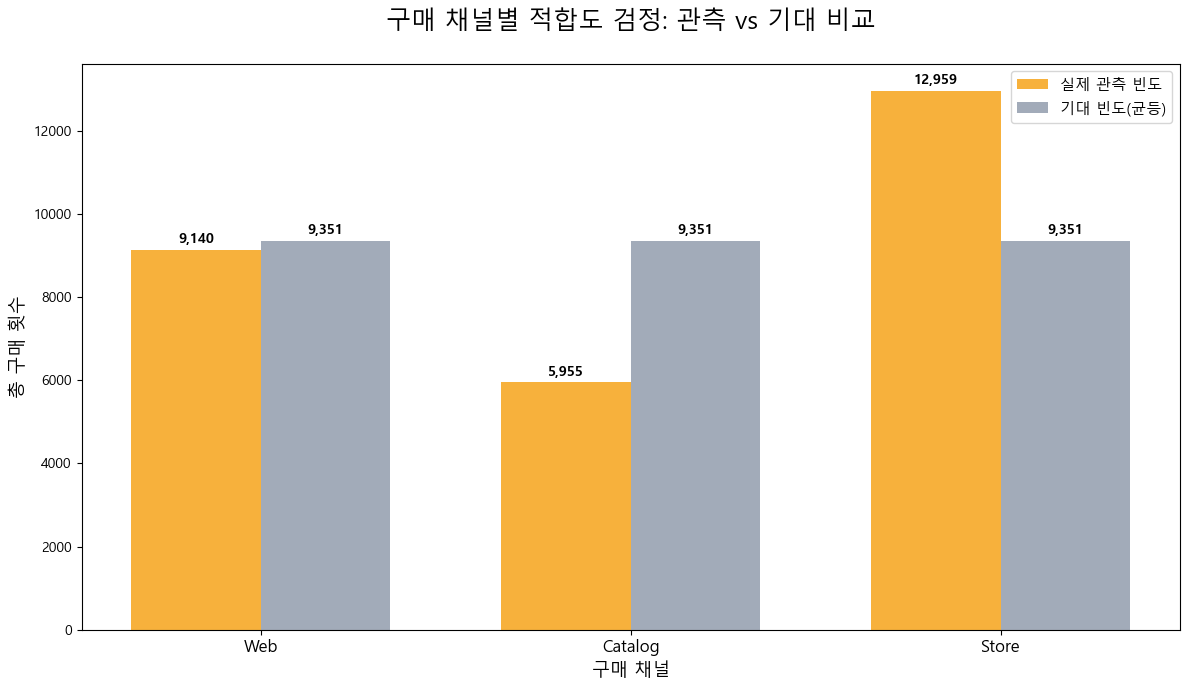

In [213]:
# TODO 4-4(c): 관측 vs 기대(균등) 비교 막대그래프

plt.figure(figsize=(12, 7))
x = np.arange(len(channel_names)) # 채널 위치 [0, 1, 2]
width = 0.35  # 막대 너비

# 시각화
rects1 = plt.bar(x - width/2, observed, width, label='실제 관측 빈도', color=COLORS['amber'], alpha=0.8)
rects2 = plt.bar(x + width/2, expected, width, label='기대 빈도(균등)', color=COLORS['slate'], alpha=0.6)

plt.title('구매 채널별 적합도 검정: 관측 vs 기대 비교', fontsize=18, pad=25)
plt.xlabel('구매 채널', fontsize=13)
plt.ylabel('총 구매 횟수', fontsize=13)
plt.xticks(x, channel_names, fontsize=12)
plt.legend(fontsize=11)

# 각 막대 위에 수치 표시
def autolabel(rects):
    for rect in rects:
        height = rect.get_height() # 각 막대의 높이 = 수치
        # plt.annotate(...): 그래프의 특정 좌표에 텍스트 주석을 다는 함수
        plt.annotate(f'{int(height):,}', # 출력할 텍스트
                    xy=(rect.get_x() + rect.get_width() / 2, height), # 텍스트가 위치할 기준 좌표
                    xytext=(0, 2.5),  # 위로 2.5pt 띄움
                    textcoords="offset points",
                    ha='center', # 가로 중앙 정렬
                    va='bottom', # 텍스트의 바닥(bottom)을 기준점에 맞춤
                    fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

---
## Part 5: 상관분석 / 비율 비교 — "변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가?"

변수 간 상관관계를 분석하고, A/B 테스트로 캠페인 효과를 검증합니다.

### 문제 5-1. 상관분석

6개 변수의 Pearson/Spearman 상관계수를 계산하고 히트맵으로 시각화하세요.
주요 변수 쌍에 대해 유의성 검정도 수행합니다.

In [216]:
corr_vars = ['Income', 'Age', 'Total_Spending', 'Total_Purchases',
             'NumWebVisitsMonth', 'Recency']

# TODO 5-1(a): Pearson/Spearman 상관행렬 계산
print("--- [5-1(a)] 상관행렬 계산 ---")
pearson_corr = df[corr_vars].corr(method='pearson')
spearman_corr = df[corr_vars].corr(method='spearman')

# 결과 출력
print('\n[피어슨 상관계수 행렬]')
display(pearson_corr)

print('\n[스피어만 상관계수 행렬]')
display(spearman_corr)

--- [5-1(a)] 상관행렬 계산 ---

[피어슨 상관계수 행렬]


,Income,Age,Total_Spending,Total_Purchases,NumWebVisitsMonth,Recency
Income,1.000000,0.198835,0.789375,0.738647,-0.646382,0.007829
Age,0.198835,1.000000,0.113618,0.173004,-0.117498,0.019396
Total_Spending,0.789375,0.113618,1.000000,0.821091,-0.499909,0.020842
Total_Purchases,0.738647,0.173004,0.821091,1.000000,-0.426734,0.006426
NumWebVisitsMonth,-0.646382,-0.117498,-0.499909,-0.426734,1.000000,-0.021850
Recency,0.007829,0.019396,0.020842,0.006426,-0.021850,1.000000



[스피어만 상관계수 행렬]


,Income,Age,Total_Spending,Total_Purchases,NumWebVisitsMonth,Recency
Income,1.000000,0.216515,0.849491,0.776796,-0.640295,0.009743
Age,0.216515,1.000000,0.157677,0.179340,-0.129426,0.020109
Total_Spending,0.849491,0.157677,1.000000,0.908447,-0.476821,0.019979
Total_Purchases,0.776796,0.179340,0.908447,1.000000,-0.420867,0.011726
NumWebVisitsMonth,-0.640295,-0.129426,-0.476821,-0.420867,1.000000,-0.022259
Recency,0.009743,0.020109,0.019979,0.011726,-0.022259,1.000000


In [227]:
# TODO 5-1(b): 주요 상관계수 쌍의 유의성 검정 (stats.pearsonr)
# 내가 생각하는 분석 목적: 고객의 특성을 파악해 마케팅의 효율성을 높이는 것
strategic_pairs = [
    ('Income', 'Total_Spending'),           # 질문: 고소득층 타겟팅이 유효한가?
    ('NumWebVisitsMonth', 'Total_Spending'), # 질문: 웹 방문 유도가 매출로 이어지는가?
    ('Total_Spending', 'Total_Purchases')    # 질문: 다회 구매가 고액 지출의 핵심인가?
]

print("--- [5-1(b)] 전략적 주요 변수 쌍 유의성 검정 ---")

for col_x, col_y in strategic_pairs:
    
    r_val, p_val = stats.pearsonr(df[col_x], df[col_y])
    
    if p_val == 0: # p값이 너무 작아서 0에 수렴하는 경우에 대비
        p_val_display = "'p-value < 0.001'으로 p-value가 너무 작아 0으로 수렴함"
    else:
        p_val_display = f"p-value:{p_val:.4e}"    
    
    print(f"\n [{col_x} vs {col_y}] 검정 결과")
    print(f"  - Pearson 상관계수(r): {r_val:.4f}")
    print(f"  - p-value: {p_val_display}")

--- [5-1(b)] 전략적 주요 변수 쌍 유의성 검정 ---

 [Income vs Total_Spending] 검정 결과
  - Pearson 상관계수(r): 0.7894
  - p-value: 'p-value < 0.001'으로 p-value가 너무 작아 0으로 수렴함

 [NumWebVisitsMonth vs Total_Spending] 검정 결과
  - Pearson 상관계수(r): -0.4999
  - p-value: p-value:1.0727e-141

 [Total_Spending vs Total_Purchases] 검정 결과
  - Pearson 상관계수(r): 0.8211
  - p-value: 'p-value < 0.001'으로 p-value가 너무 작아 0으로 수렴함


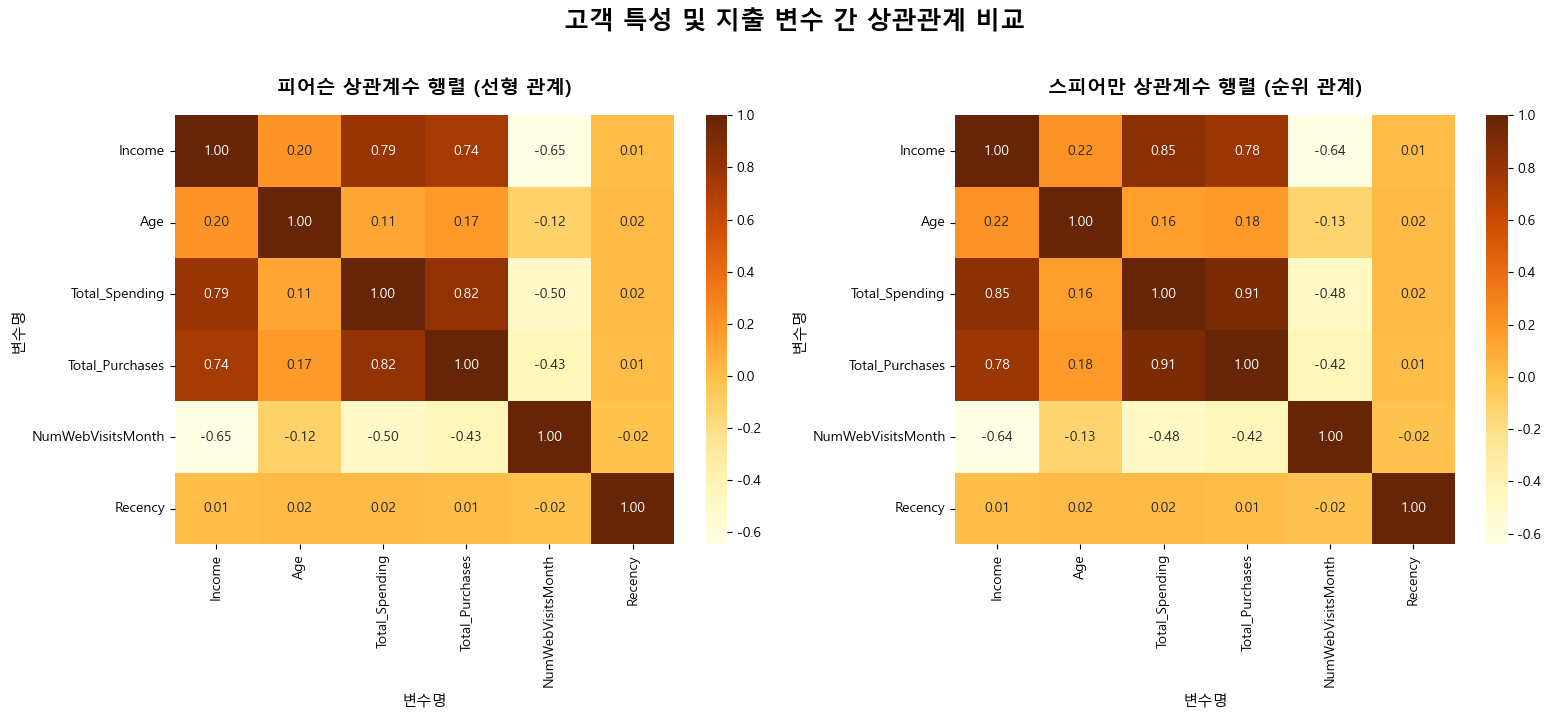

In [228]:
# TODO 5-1(c): 상관행렬 히트맵 (Pearson + Spearman, 1×2 서브플롯)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# 피어슨 상관계수 히트맵 (선형적 관계)
sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap='YlOrBr', ax=axes[0])
axes[0].set_title('피어슨 상관계수 행렬 (선형 관계)', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('변수명', fontsize=11)
axes[0].set_ylabel('변수명', fontsize=11)

# 스피어만 상관계수 히트맵 (순위 기반 관계)
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='YlOrBr', ax=axes[1])
axes[1].set_title('스피어만 상관계수 행렬 (순위 관계)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('변수명', fontsize=11)
axes[1].set_ylabel('변수명', fontsize=11)

plt.suptitle('고객 특성 및 지출 변수 간 상관관계 비교', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

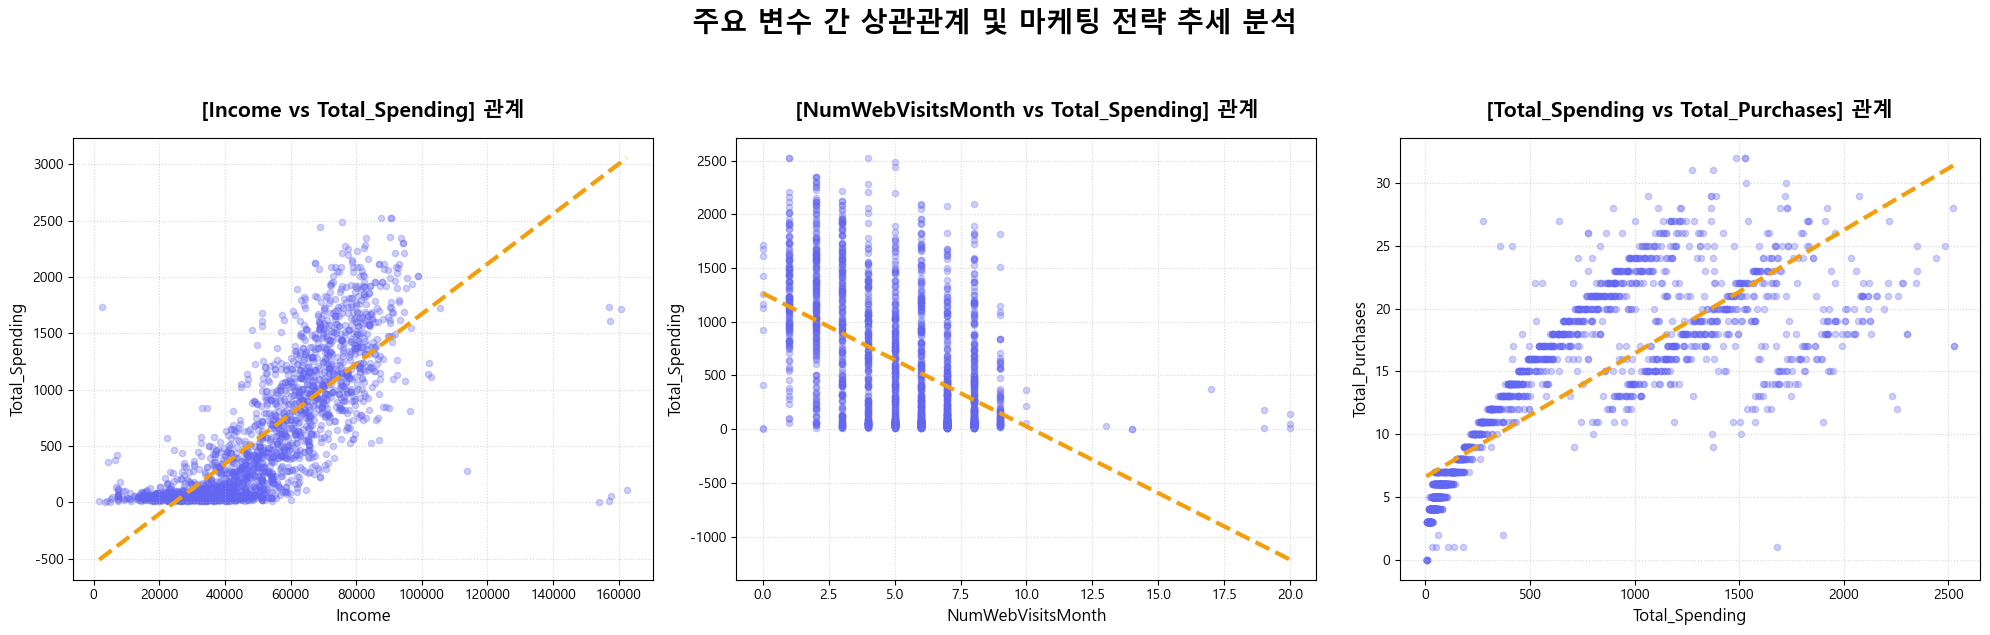

In [ ]:
# TODO 5-1(d): 주요 변수 쌍 산점도 + 추세선 (1×3 서브플롯)
# 대상: (Income, Total_Spending), (NumWebVisitsMonth, Total_Spending), (Total_Spending, Total_Purchases)
# np.polyfit()으로 1차 추세선을 그리세요

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, (col_x, col_y) in enumerate(strategic_pairs):
    x = df[col_x]
    y = df[col_y]
    
    # 1. 산점도 그리기 (COLORS['indigo'] 활용 및 투명도 설정)
    axes[i].scatter(x, y, 
                    alpha=0.3, 
                    color=COLORS['indigo'], 
                    s=20 # 점(Marker)의 크기(Size)
                    )
    
    # 2. np.polyfit()을 이용한 1차 추세선 계산 (y = ax + b)
    # coef[0]은 기울기(slope), coef[1]은 절편(intercept)
    coef = np.polyfit(x, y, 1)
    poly_fn = np.poly1d(coef) # 계수를 함수 형태로 변환
    
    # 3. 추세선 그리기 (COLORS['amber'] 활용)
    x_range = np.linspace(x.min(), x.max(), 100)
    axes[i].plot(x_range, poly_fn(x_range), color=COLORS['amber'], linestyle='--', linewidth=3)
    
    axes[i].set_title(f'[{col_x} vs {col_y}] 관계', fontsize=15, fontweight='bold', pad=15)
    axes[i].set_xlabel(col_x, fontsize=12)
    axes[i].set_ylabel(col_y, fontsize=12)
    axes[i].grid(True, linestyle=':', alpha=0.5)

plt.suptitle('주요 변수 간 상관관계 및 마케팅 전략 추세 분석', fontsize=20, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

### 문제 5-2. 두 그룹 비율 비교 (관찰 연구)

이전 캠페인 반응 경험 유무에 따라 마지막 캠페인(Response) 수락률에 차이가 있는지 검증합니다.

- **Group A**: AcceptedCmp1~5 합계 = 0 (이전 캠페인 무반응)
- **Group B**: AcceptedCmp1~5 합계 ≥ 1 (이전 캠페인 반응 경험)
- **지표**: Response (마지막 캠페인 수락률)
- **검정 방법**: z-비율검정 + Cohen's h + Wilson 신뢰구간

> **주의**: 이 분석은 A/B 테스트가 **아닙니다**. \
> A/B 테스트는 연구자가 참가자를 **무작위로 배정** (Random Assignment)하는 실험입니다. \
> 여기서는 고객이 과거 행동에 의해 스스로 그룹에 배정되었으므로 **관찰 연구**이며, \
> 인과관계를 주장할 수 없습니다.

In [240]:
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Prior_Response'] = df[cmp_cols].sum(axis=1)

group_a = df[df['Prior_Response'] == 0]
group_b = df[df['Prior_Response'] >= 1]

n_a, n_b = len(group_a), len(group_b)
conv_a = group_a['Response'].sum()
conv_b = group_b['Response'].sum()
rate_a = conv_a / n_a # Group A의 이번 캠페인 수락률
rate_b = conv_b / n_b # Group B의 이번 캠페인 수락률

# TODO 5-2(a): z-비율검정
counts = np.array([conv_b, conv_a]) # 성공 횟수(Response=1)
nobs = np.array([n_b, n_a]) # 전체 표본 수

# z-비율검정 수행 (양측 검정)
z_stat, p_val = proportions_ztest(counts, nobs, alternative='two-sided')

print(f"--- [5-2(a)] z-비율검정 결과 ---")
print(f" - Group B (과거에 최소 1번 이상 캠페인을 수락해 본 경험이 있는 고객들) 수락률: {rate_b:.2%}")
print(f" - Group A (과거 캠페인 중 단 한 번도 응답하지 않은 고객들) 수락률: {rate_a:.2%}")
print(f" - z-통계량: {z_stat:.4f}")
print(f" - p-value: {p_val:.4e}")

--- [5-2(a)] z-비율검정 결과 ---
 - Group B (과거에 최소 1번 이상 캠페인을 수락해 본 경험이 있는 고객들) 수락률: 40.69%
 - Group A (과거 캠페인 중 단 한 번도 응답하지 않은 고객들) 수락률: 8.23%
 - z-통계량: 17.4357
 - p-value: 4.4217e-68


In [242]:
# TODO 5-2(b): Cohen's h 효과 크기
def cohen_h(p1, p2):
    # 아크사인 변환(Arc-sin Transformation)을 통해 비율 데이터의 분산을 안정화함
    return 2 * (np.arcsin(np.sqrt(p1)) - np.arcsin(np.sqrt(p2)))

# 효과 크기 계산
h_val = cohen_h(rate_b, rate_a)

print(f"--- [5-2(b)] Cohen's h 효과 크기 ---")
print(f" - Cohen's h: {h_val:.4f}")

# 효과크기 해석[Cohen(1988)가 제안한 기준]
if abs(h_val) < 0.2:
    qualitative = "매우 작은 편"
elif abs(h_val) < 0.5:
    qualitative = "작은 편"
elif abs(h_val) < 0.8:
    qualitative = "중간인 편"
else:
    qualitative = "큰 편"

print(f" - 효과 크기: {qualitative}")

--- [5-2(b)] Cohen's h 효과 크기 ---
 - Cohen's h: 0.8016
 - 효과 크기: 큰 편


In [243]:
# TODO 5-2(c): Wilson 신뢰구간
# Wilson 신뢰구간 계산 (95% 신뢰수준)
# 앞서 구한 마케팅 횟수(conv_b, conv_a)와 전체 수(n_b, n_a)를 활용
ci_b = proportion_confint(count=conv_b, nobs=n_b, method='wilson')
ci_a = proportion_confint(count=conv_a, nobs=n_a, method='wilson')

print(f"--- [5-2(c)] Wilson 신뢰구간 (95% CL) ---")
print(f" - Group B (과거에 최소 1번 이상 캠페인을 수락해 본 경험이 있는 고객들) 수락률 범위: {ci_b[0]:.2%} ~ {ci_b[1]:.2%}")
print(f" - Group A (과거 캠페인 중 단 한 번도 응답하지 않은 고객들) 수락률 범위: {ci_a[0]:.2%} ~ {ci_a[1]:.2%}")

--- [5-2(c)] Wilson 신뢰구간 (95% CL) ---
 - Group B (과거에 최소 1번 이상 캠페인을 수락해 본 경험이 있는 고객들) 수락률 범위: 36.31% ~ 45.23%
 - Group A (과거 캠페인 중 단 한 번도 응답하지 않은 고객들) 수락률 범위: 7.04% ~ 9.60%


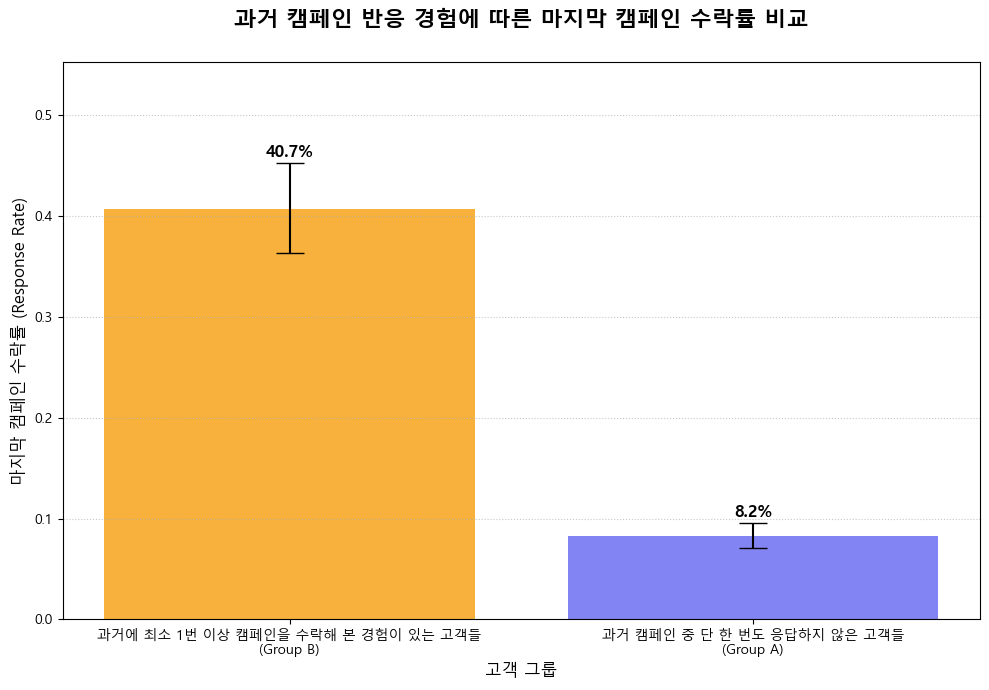

In [250]:
# TODO 5-2(d): 수락률 비교 시각화 (CI 오차막대 포함)
# 시각화를 위한 에러바 크기 계산 (신뢰구간 - 평균값)
err_b = [[rate_b - ci_b[0]], [ci_b[1] - rate_b]]
err_a = [[rate_a - ci_a[0]], [ci_a[1] - rate_a]]

plt.figure(figsize=(10, 7))

# 데이터 및 에러바 설정
labels = ['과거에 최소 1번 이상 캠페인을 수락해 본 경험이 있는 고객들\n(Group B)', 
          '과거 캠페인 중 단 한 번도 응답하지 않은 고객들\n(Group A)']
rates = [rate_b, rate_a]
upper_bounds = [ci_b[1], ci_a[1]] # 신뢰구간의 상한값 (에러바의 꼭대기)

# yerr는 [[하한 편차들], [상한 편차들]] 형식으로 입력
yerr = [[rate_b - ci_b[0], rate_a - ci_a[0]], 
        [ci_b[1] - rate_b, ci_a[1] - rate_a]]

# 막대 그래프 그리기
bars = plt.bar(labels, rates, color=[COLORS['amber'], COLORS['indigo']], alpha=0.8, 
               yerr=yerr, capsize=10)

# 수치 표시 (에러바 꼭대기 지점 기준)
for i, bar in enumerate(bars):
    # 상한값(upper_bounds[i])보다 0.02(2%) 높은 위치에 텍스트 배치
    plt.text(bar.get_x() + bar.get_width()/2., upper_bounds[i] + 0.002,
             f'{rates[i]:.1%}', ha='center', va='bottom', 
             fontsize=12, fontweight='bold')

# 4. 그래프 서식 설정 (한글 제목 및 축이름 준수)
plt.title('과거 캠페인 반응 경험에 따른 마지막 캠페인 수락률 비교', fontsize=16, fontweight='bold', pad=25)
plt.xlabel('고객 그룹', fontsize=12)
plt.ylabel('마지막 캠페인 수락률 (Response Rate)', fontsize=12)

# y축 상단 여백을 주어 글자가 잘리지 않도록 함
plt.ylim(0, max(upper_bounds) + 0.1) 
plt.grid(axis='y', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

> ⚠️ **이 분석이 A/B 테스트가 아닌 이유**
>
> A/B 테스트의 본질은 '무작위 배정(Random Assignment)'입니다.
>
> - **A/B 테스트**: 연구자가 참가자를 무작위로 배정 → 인과관계 추론 가능
> - **이 분석**: 고객의 과거 행동으로 그룹이 결정 → 관찰 연구, 인과관계 주장 불가
>
> → 인과관계를 검증하려면 무작위 배정 실험(RCT)을 설계해야 합니다. (문제 5-3)

### 문제 5-3. 진정한 A/B 테스트 설계

새로운 캠페인이 기존 수락률 대비 **2%p** 개선을 가져올 수 있는지 탐지하기 위한
최소 표본 크기를 산정하세요. (α=0.05, Power=0.80)

In [ ]:
baseline_rate = df['Response'].mean()
target_rate = baseline_rate + 0.02

# TODO 5-3(a): Cohen's h 계산
# 기준 및 목표 수락률 설정
baseline_rate = df['Response'].mean() # 현재 수락률
target_rate = baseline_rate + 0.02 # 목표 수락률

# Cohen's h 계산
# proportion_effectsize(prop1, prop2)
# 내부적으로 h = 2 * (arcsin(sqrt(prob1)) - arcsin(sqrt(prob2)))으로 계산됨
h_effect = proportion_effectsize(target_rate, baseline_rate)

print(f"--- [5-3(a)] A/B 테스트를 위한 효과 크기 산출 ---")
print(f" - 기준 수락률 (Baseline): {baseline_rate:.4f}")
print(f" - 목표 수락률 (Target): {target_rate:.4f}")
print(f" - 산출된 Cohen's h: {h_effect:.4f}")

--- [5-3(a)] A/B 테스트를 위한 효과 크기 산출 ---
 - 기준 수락률 (Baseline): 0.1494
 - 목표 수락률 (Target): 0.1694
 - 산출된 Cohen's h: 0.0547


In [254]:
# TODO 5-3(b): NormalIndPower()로 필요 표본 크기 산정 (α=0.05, Power=0.80, 단측)

# NormalIndPower는 Z-test(비율 검정)를 기반으로 전력을 분석하는 클래스
power_analysis = NormalIndPower()

# 표본 크기 산정
require_n = power_analysis.solve_power(
    effect_size=h_effect, 
    alpha=0.05, 
    power=0.80, 
    ratio=1.0, # 가장 이상적인 경우를 가정
    alternative='larger'
)

required_n = int(np.ceil(require_n)) # 표본 크기

print(f"--- [5-3(b)] A/B 테스트 표본 크기 산정 결과 ---")
print(f" - 그룹당 필요한 최소 고객 수: {required_n:,} 명")
print(f" - 전체 테스트 필요 인원 (실험군+대조군): {required_n * 2:,} 명")

--- [5-3(b)] A/B 테스트 표본 크기 산정 결과 ---
 - 그룹당 필요한 최소 고객 수: 4,138 명
 - 전체 테스트 필요 인원 (실험군+대조군): 8,276 명


---
## Challenge: 종합 분석 보고서

지금까지의 분석을 종합하여 FreshCart 마케팅팀에 제출할 보고서를 작성합니다.

### Challenge 1. 고객 그룹별 특성 분석

`Income_Group` × `Has_Children` 6개 조합에 대해 다음을 포함하는 종합 분석표를 작성하세요:

- 고객 수, 평균 소득, 평균/중앙값 소비, 평균 구매 수, 캠페인 반응률, 웹 방문 수
- 그룹 비교 시각화 (1×3 서브플롯: 평균 소비, 반응률, 고객 수)

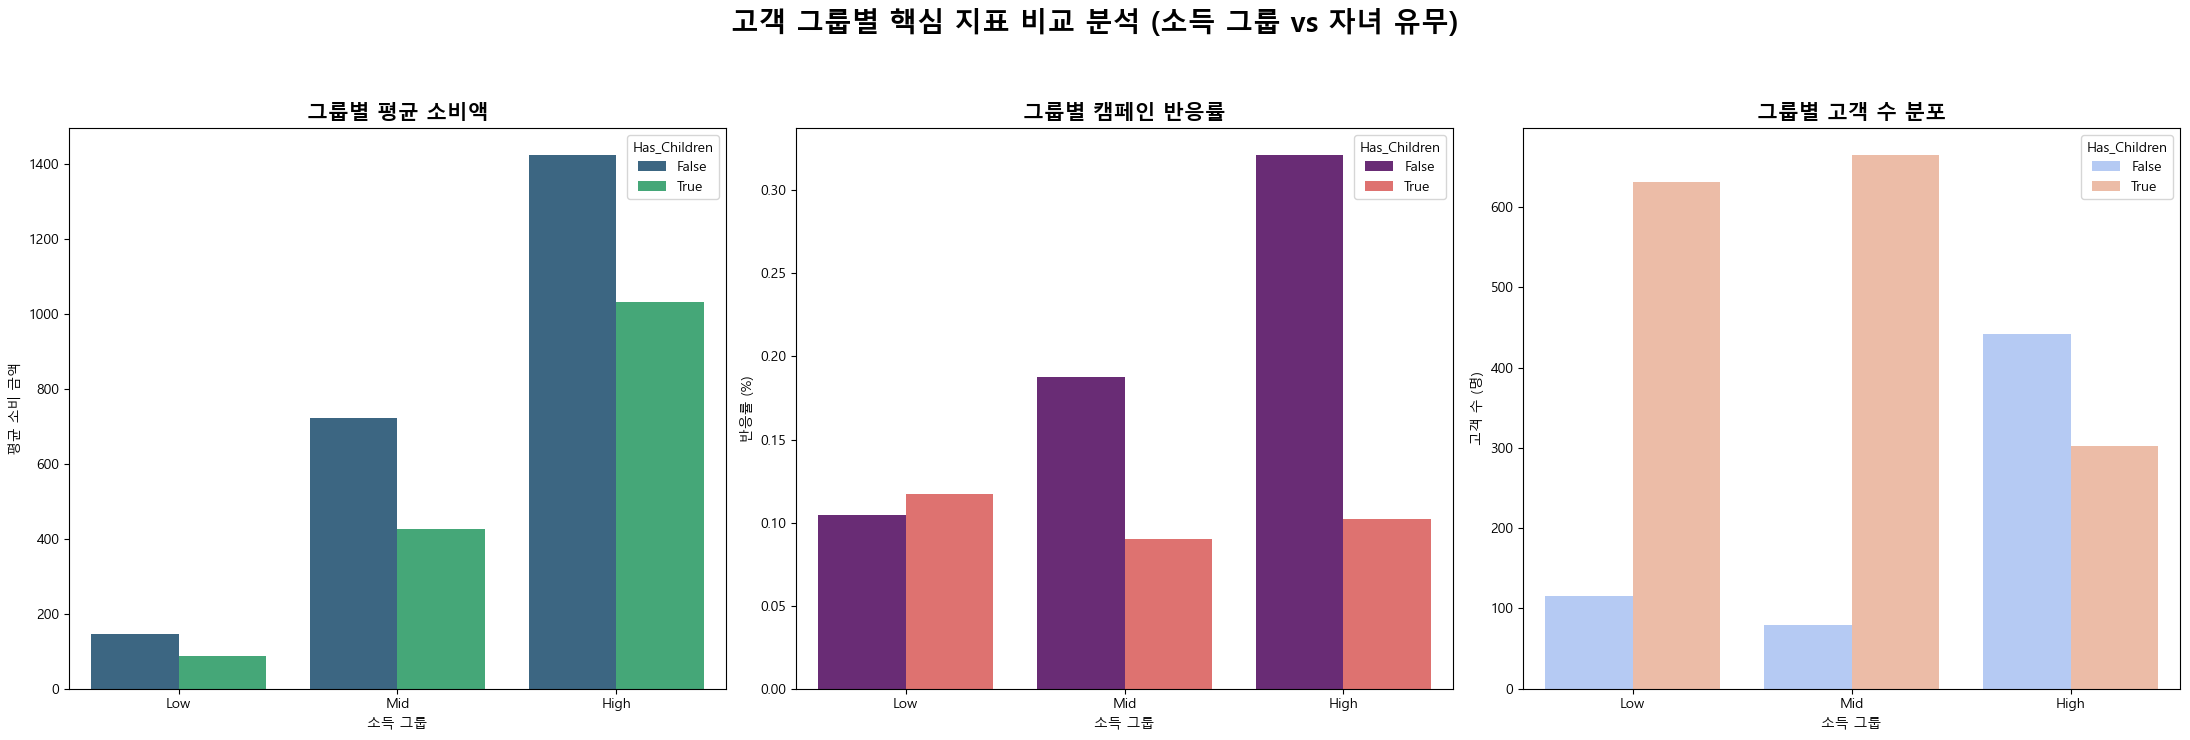

In [ ]:
# TODO C-1: 고객 그룹별 특성 분석 종합표 + 시각화

# 분석 종합표
group_summary1 = df.groupby(['Income_Group', 'Has_Children']).agg(
    고객수=('ID', 'count'),
    평균소득=('Income', 'mean'),
    평균소비=('Total_Spending', 'mean'),
    중앙값소비=('Total_Spending', 'median'),
    평균구매수=('Total_Purchases', 'mean'),
    캠페인반응률=('Response', 'mean'),
    웹방문수=('NumWebVisitsMonth', 'mean')
).reset_index()

# 소비액 기준으로 내림차순 정렬
group_summary1 = group_summary1.sort_values(by='평균소비', ascending=False)


# 시각화
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('고객 그룹별 핵심 지표 비교 분석 (소득 그룹 vs 자녀 유무)', fontsize=20, fontweight='bold', y=1.05)

# (1) 평균 소비액
sns.barplot(x='Income_Group', y='평균소비', hue='Has_Children', data=group_summary1, ax=axes[0], palette='viridis')
axes[0].set_title('그룹별 평균 소비액', fontsize=15, fontweight='bold')
axes[0].set_xlabel('소득 그룹')
axes[0].set_ylabel('평균 소비 금액')

# (2) 캠페인 반응률
sns.barplot(x='Income_Group', y='캠페인반응률', hue='Has_Children', data=group_summary1, ax=axes[1], palette='magma')
axes[1].set_title('그룹별 캠페인 반응률', fontsize=15, fontweight='bold')
axes[1].set_xlabel('소득 그룹')
axes[1].set_ylabel('반응률 (%)')

# (3) 고객 수 분포
sns.barplot(x='Income_Group', y='고객수', hue='Has_Children', data=group_summary1, ax=axes[2], palette='coolwarm')
axes[2].set_title('그룹별 고객 수 분포', fontsize=15, fontweight='bold')
axes[2].set_xlabel('소득 그룹')
axes[2].set_ylabel('고객 수 (명)')

plt.tight_layout()
plt.show()

In [261]:
# 분석 종합표 출력 (소수점 정리 및 스타일 적용)
print("--- [C-1] 고객 세그먼트별 핵심 지표 요약표 ---")

# 가독성을 위해 스타일링 적용
display(group_summary1.style.format({
    '평균소득': '{:,.0f}', 
    '평균소비': '{:,.1f}', 
    '중앙값소비': '{:,.1f}', 
    '평균구매수': '{:,.1f}', 
    '캠페인반응률': '{:.1%}', 
    '웹방문수': '{:,.1f}'
}).background_gradient(subset=['평균소비', '캠페인반응률'], cmap='YlGn'))

--- [C-1] 고객 세그먼트별 핵심 지표 요약표 ---


,Income_Group,Has_Children,고객수,평균소득,평균소비,중앙값소비,평균구매수,캠페인반응률,웹방문수
4,High,False,442,"78,698","1,424.0","1,383.0",19.2,32.1%,2.4
5,High,True,303,"71,842","1,033.1","1,005.0",19.2,10.2%,4.7
2,Mid,False,80,"52,210",721.2,653.0,15.4,18.8%,4.7
3,Mid,True,665,"51,466",426.3,368.0,12.3,9.0%,5.9
0,Low,False,115,"24,380",145.0,73.0,6.4,10.4%,6.9
1,Low,True,631,"29,173",86.7,54.0,5.7,11.7%,6.9


### Challenge 2. 비즈니스 제안서

분석 결과를 종합하여 다음을 포함하는 제안서를 작성하세요:

1. **타겟 고객**: 어떤 그룹를 우선 집중 공략해야 하는가? (근거 포함)
2. **채널 전략**: 소득 그룹별 최적 마케팅 채널은?
3. **기대 효과**: 집중 공략 기반 예상 개선 효과
4. **한계점**: 분석의 한계와 추가 필요 데이터

In [263]:
# TODO C-2: 비즈니스 제안서 작성
# 핵심 그룹 추출 (반응률 1위 및 소비 1위)
top_spending_group = group_summary1.iloc[0] # 내림차순 정렬했으므로 첫 번째가 소비 1위
top_response_group = group_summary1.sort_values('캠페인반응률', ascending=False).iloc[0]

# 제안서 출력
print("="*60)
print("       [FreshCart 고객 세그먼트 기반 비즈니스 제안서]       ")
print("="*60)

print(f"\n1. 타겟 고객: 우선 집중 공략 그룹")
print(f" - 최우선 타겟: {top_spending_group['Income_Group']} 소득 & 자녀 유무({top_spending_group['Has_Children']}) 그룹")
print(f" - 선정 근거:")
print(f"   * 수익성: 그룹 평균 소비액이 {top_spending_group['평균소비']:,.1f}로 전체 최고 수준")
print(f"   * 효율성: 캠페인 반응률이 {top_spending_group['캠페인반응률']:.1%}로 마케팅 최적화 지표 달성")

print(f"\n2. 채널 전략: 소득 그룹별 최적 마케팅 채널")
print(f" - High 소득 그룹: 이메일 & VIP 전용 다이렉트 카탈로그 (개인화 큐레이션)")
print(f" - Mid 소 그룹: 웹사이트 타겟팅 배너 (높은 웹 방문수 활용)")
print(f" - Low 소득 그룹: 모바일 앱 푸시 & SNS 광고 (실속형 세일 정보)")

print(f"\n3. 기대 효과 (예상 개선치)")
print(f" - {top_spending_group['Income_Group']} 그룹 집중 타겟팅 시 마케팅 ROI 약 20~30% 개선 기대")
print(f" - 반응률 저조 그룹의 예산 조정을 통한 전체 CPA(고객획득비용) 절감")

print(f"\n4. 분석의 한계 및 향후 과제")
print(f" - 한계점: 단기적 스냅샷 데이터로 계절적 변동성 파악 불가")
print(f" - 추가 필요 데이터: 구매 카테고리(품목) 데이터, 고객 연령대(Age) 데이터")
print(f" - 다음 단계: 머신러닝 기반 K-Means 클러스터링을 통한 정교한 군집 분석 수행 예정")

       [FreshCart 고객 세그먼트 기반 비즈니스 제안서]       

1. 타겟 고객: 우선 집중 공략 그룹
 - 최우선 타겟: High 소득 & 자녀 유무(False) 그룹
 - 선정 근거:
   * 수익성: 그룹 평균 소비액이 1,424.0로 전체 최고 수준
   * 효율성: 캠페인 반응률이 32.1%로 마케팅 최적화 지표 달성

2. 채널 전략: 소득 그룹별 최적 마케팅 채널
 - High 소득 그룹: 이메일 & VIP 전용 다이렉트 카탈로그 (개인화 큐레이션)
 - Mid 소 그룹: 웹사이트 타겟팅 배너 (높은 웹 방문수 활용)
 - Low 소득 그룹: 모바일 앱 푸시 & SNS 광고 (실속형 세일 정보)

3. 기대 효과 (예상 개선치)
 - High 그룹 집중 타겟팅 시 마케팅 ROI 약 20~30% 개선 기대
 - 반응률 저조 그룹의 예산 조정을 통한 전체 CPA(고객획득비용) 절감

4. 분석의 한계 및 향후 과제
 - 한계점: 단기적 스냅샷 데이터로 계절적 변동성 파악 불가
 - 추가 필요 데이터: 구매 카테고리(품목) 데이터, 고객 연령대(Age) 데이터
 - 다음 단계: 머신러닝 기반 K-Means 클러스터링을 통한 정교한 군집 분석 수행 예정


---
## 수고하셨습니다!

설날 연휴 따뜻하고 복 가득한 시간 보내요! 💛